<img src="image/dimeslogo.png" width="350" height="350" align="left"/>

<h1><center>Progetto Esame:
<h1><center>Analisi di Social Network e Media

# Candidato: Scuderi Ivan 216635

# Scopo dell'analisi

Il seguente progetto è stato sviluppato con lo scopo di andare ad impiegare e testare l'architettura __transformers BERT__ su dataset di diversa natura e contesto, con il fine di valutarne le prestazioni ottenute. Il problema di classificazione che si andrà a risolvere fa quindi parte dei _task_ di _Sentiment Analysis_, a tale scopo la scelta dei dati di partenza è stata svolta con l'intenzione di impiegare fonti testuali variegate, provenienti da differenti sorgenti e inerenti a differenti contesti. \
Una caratteristica fondamentale nella scelta è stata anche la numerosità dell'insieme delle etichette e la lunghezza dei testi, si potrà infatti osservare come ognuno dei singoli insiemi reperiti differisce per numero di _label_. \
In particolare sono stati impiegati i suddetti dataset:
>* <dt>Twitter Dataset:</dt>
><dd>Collezione di tweet provenienti dalla piattaforma di social network Twitter, tale collezione in particolare presenta come argomento principale dei tweet la pandemia di Corona Virus.</dd>
>* <dt>IMDB Dataset:</dt>
><dd>Insieme di recensioni su film o serie tv caricate sul portale web IMDb, la lunghezza di tali testi è nettamente superiore rispetto agli altri due dataset, il contesto specifico è invece l'ambito cinematografico.</dd>
>* <dt>Emotion Dataset:</dt>
><dd>Insieme di frasi etichettate con il sentiment vero e proprio che queste esprimono, la scelta di tale dataset è stata fatta per via dell'elevato numero di etichette di classe presenti.</dd>

<img src="image/bert.png" width="300" height="200" align="center"/>

Inoltre si andrà ad impiegare l'implementazione dell'architettura __BERT__ della libreria __huggingface__ tramite l'utilizzo dei due moduli pre-addestrati: __BertTokenizerFast__, tokenizzatore che verà impiegato ai fini delle operazioni di _preprocessing_ per poter ottenere l'input nella forma in cui lo richiede il modello di _embedding_. Ed il __TFBertModel__, modello di embedding specifico per l'utilizzo insieme alla libreria _tensorflow_, che avrà il compito di effettuare l'encoding del testo nello spazio trasformato.

# Import preliminari

In [1]:
# librerie di base per il caricamento, manipolazione e visualizzazione dei dati
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os

# librerie necessarie per le operazioni di pre-processing del testo
import re, string
import emoji
from gensim.parsing.preprocessing import remove_stopwords 

# librerie per la costruzione dei modelli di Deep Learning
import tensorflow as tf
from tensorflow import keras
from keras.utils.layer_utils import count_params

# librerie per l'utilizzo dell'architettura transformers BERT
from transformers import BertTokenizerFast
from transformers import TFBertModel

# metriche di valutazione dei modelli
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

# utilità
from wordcloud import WordCloud
from PIL import Image
import pickle

# path 
DATASET_DIR = r'.\dataset'
DATASET_TWEET = os.path.join(DATASET_DIR, 'Corona_Tweet_Dataset')
DATASET_IMDB = os.path.join(DATASET_DIR, 'IMDB_Dataset')
DATASET_EMOTION = os.path.join(DATASET_DIR, 'Emotion_Dataset')
DUMP_DIR = r'.\dump'
PREPROC_DIR = r'.\preproc'

# imposto un seed sui valori random per la riproducibilità dei risultati
SEED = 44
tf.keras.utils.set_random_seed(SEED)

# imposto lo stile grafico dei plot
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

# disabilito i warnings di jupyter
import warnings
from transformers import logging
warnings.filterwarnings('ignore')
logging.set_verbosity_error()

<Figure size 432x288 with 0 Axes>

# Caricamento dei dataset

In [2]:
# Twitter DS (necessatio impiegare un encoding diverso da UTF-8 per il caricamento del training set)
twitter_train = pd.read_csv(os.path.join(DATASET_TWEET, 'train.csv'), encoding='ISO-8859-1')
twitter_test = pd.read_csv(os.path.join(DATASET_TWEET, 'test.csv'))

# IMDB DS (presente solo il dataset di training si dovrà ottenere il test set tramite split)
imdb_ds = pd.read_csv(os.path.join(DATASET_IMDB, 'train.csv'))

#Emotion DS (presente anche il validation set, leggo i file txt come csv usando il separatore ';')
emotion_train = pd.read_csv(os.path.join(DATASET_EMOTION, 'train.txt'), names=['text', 'emotion'], sep=';')
emotion_val = pd.read_csv(os.path.join(DATASET_EMOTION, 'val.txt'), names=['text', 'emotion'], sep=';')
emotion_test = pd.read_csv(os.path.join(DATASET_EMOTION, 'test.txt'), names=['text', 'emotion'], sep=';')

Si può notare come si abbia a disposizione il _test set_ sia per il __Twitter Dataset__ che per l' __Emotion Dataset__, di cui addirittura si dispone anche il _validation set_. Situazione differente si ha invece per quando riguarda l' __IMDB Dataset__, si dovrà quindi effettuare in seguito uno split della singola fonte dati.

Nel proseguo del lavoro progettuale si provvederà ad effettuare singolarmente una prima fase di analisi e visualizzazione dei vari dataset, per poi successivamente sviluppare le necessarie operazioni di _data cleaning_ e _preprocessing_.

In [3]:
# definisco dei metodi generali per il cleaning e preprocessing del testo

def rimuovi_spazi(text): # rimuovo gli spazi multipli all'interno del testo, il ritorno a capo ed il fine linea
    text = text.replace('\r', '').replace('\n', ' ')
    return re.sub("\s\s+" , " ", text)

def rimuovi_emoji(text): # rimuovo le emoji dal testo
    return emoji.replace_emoji(text, replace='')

def clean(text): # pulizia generale del testo
    text = re.sub(r'[^\x20-\x7F]+', " ", text) # rimuovo i carattere con codifica non UTF-8/ASCII
    text = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', "", text) # rimuovo i link
    text = re.sub(r'[A-Za-z0-9]+@[A-Za-z]*\.?[A-Za-z0-9]*', "", text) #rimuovo gli indirizzi email
    text = re.sub(r'@([A-Za-z0-9_]+)', "", text) # rimuovo i nomi utenti
    text = re.sub('<[^<]+?>', '', text) # rimuovo di markup
    text = text.replace("'", '') # accorpo le parole divise da apostrofo
    da_eliminare = string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§' # caratteri strani da eliminare + punteggiatura
    text = "".join([char if char not in da_eliminare else " " for char in text]) # rimuovo i da_eliminare
    text = re.sub(r'\b[0-9]+\b\s*', '', text) # rimuovo i numeri
    text = text.lower() # pongo tutto in minuscolo
    text = text.strip() # elimino eventuali spazi ad inizio e fine testo
    return text

def rimuovi_stopwords(text): # metodo che mi servirà per analizzare le parole con maggiore occorrenza escludendo quelle inutili
    return remove_stopwords(text)

# definisco dei metodi di utilità

def generate_frequency(ds, relative=True): # metodo che serve per generare la frequenza delle parole 
    words = " ".join(word for word in ds)
    list_label = words.split(" ") 
    set_label = set(list_label)
    dict_label = dict.fromkeys(set_label, 0.)
    tot = 0.
    for w in list_label:
        dict_label[w] += 1
        tot += 1
    if relative:
        for k in dict_label:
            dict_label[k] = dict_label[k] / tot
    return dict_label

def generate_cloud(ds, title, mask=None, words=200): # metodo che serve a generare le wordcloud
    wc = WordCloud(background_color="white", max_words=words, mask=mask)
    fig, ax = plt.subplots(len(ds['Sentiment'].unique()), 1, figsize=(15,25))
    for i, l in enumerate(ds['Sentiment'].unique()):
        ds_label = ds[ds['Sentiment'] == l]
        frequency = generate_frequency(ds_label['NoStopWords'])
        cloud = wc.generate_from_frequencies(frequency)
        ax[i].axis('off')
        ax[i].imshow(cloud, interpolation='bilinear')
        ax[i].set_title(f'{title}: {l} Label WordCloud')
    plt.tight_layout()
    plt.show()

def get_token(data, tokenizer, max_len): # metodo che permette la tokenizzazione
    input_ids = [] 
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(data[i], 
                                        add_special_tokens=True, 
                                        max_length=max_len, 
                                        padding='max_length', # si effettua padding se la len del testo è inferiore al max
                                        truncation=True, # si effettua truncation se la len del testo è superiore al max
                                        return_attention_mask=True
                                       )
        
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])    
    return np.array(input_ids),np.array(attention_masks)

def get_top_ngrams(data, n=50, g=2): # metodo che permetto di generate gli n g-grammi più frequenti nel testo
    vec = CountVectorizer(ngram_range=(g, g)).fit(data)
    bag_of_words = vec.transform(data)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    result = dict(words_freq[:n])
    return pd.DataFrame(result.values(), index = result.keys(), columns=['count'])

<img src="image/twitter_logo.jpg" width="150" height="50" align="right"/>

## Twitter Dataset

Iniziamo andando ad esplorare e descrivere le caratteristiche del __Twitter Dataset__, come detto precedentemente questo fa riferimento ad una collezione di tweet estratti dalla piattaforma di online social network _Twitter_ inerenti perciò ad un contesto di _'social life'_, in cui l'argomento predominante risulta essere la pandemia di Corona Virus.

In [4]:
print('Twitter DS:> Numero di elementi nel trainig set {};'.format(twitter_train.shape[0]))
print('Twitter DS:> Numero di elementi nel test set {};'.format(twitter_test.shape[0]))

Twitter DS:> Numero di elementi nel trainig set 41157;
Twitter DS:> Numero di elementi nel test set 3798;


In [5]:
print('Esempi Training Set:')
display(twitter_train.head(5))
print('Esempi Test Set:')
display(twitter_test.head(5))

Esempi Training Set:


UserName  ScreenName   Location     TweetAt  \
0      3799       48751     London  16-03-2020   
1      3800       48752         UK  16-03-2020   
2      3801       48753  Vagabonds  16-03-2020   
3      3802       48754        NaN  16-03-2020   
4      3803       48755        NaN  16-03-2020   

                                       OriginalTweet           Sentiment  
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...             Neutral  
1  advice Talk to your neighbours family to excha...            Positive  
2  Coronavirus Australia: Woolworths to give elde...            Positive  
3  My food stock is not the only one which is emp...            Positive  
4  Me, ready to go at supermarket during the #COV...  Extremely Negative

Esempi Test Set:


UserName  ScreenName             Location     TweetAt  \
0         1       44953                  NYC  02-03-2020   
1         2       44954          Seattle, WA  02-03-2020   
2         3       44955                  NaN  02-03-2020   
3         4       44956          Chicagoland  02-03-2020   
4         5       44957  Melbourne, Victoria  03-03-2020   

                                       OriginalTweet           Sentiment  
0  TRENDING: New Yorkers encounter empty supermar...  Extremely Negative  
1  When I couldn't find hand sanitizer at Fred Me...            Positive  
2  Find out how you can protect yourself and love...  Extremely Positive  
3  #Panic buying hits #NewYork City as anxious sh...            Negative  
4  #toiletpaper #dunnypaper #coronavirus #coronav...             Neutral

Si può notare come nel dataset sia presente un numero maggiore di informazioni rispetto a quelle di cui realmente abbiamo bisogno ai fini del progetto. Per tale motivo si procede andando ad eliminare le colonne non rilevanti:

In [6]:
columns = ['UserName', 'ScreenName', 'Location', 'TweetAt']

twitter_train = twitter_train.drop(columns=columns)
twitter_test = twitter_test.drop(columns=columns)

twitter_train.head(5)

OriginalTweet           Sentiment
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...             Neutral
1  advice Talk to your neighbours family to excha...            Positive
2  Coronavirus Australia: Woolworths to give elde...            Positive
3  My food stock is not the only one which is emp...            Positive
4  Me, ready to go at supermarket during the #COV...  Extremely Negative

Come è possibile osservare dalla stampa sottostante, fortunatamente non sono presenti valori nulli o duplicati all'interno dei due insiemi di dati.

In [7]:
train_nan = twitter_train.isna().any().sum()
train_dupl = twitter_train.duplicated(subset=['OriginalTweet']).sum()

test_nan = twitter_test.isna().any().sum()
test_dupl = twitter_test.duplicated(subset=['OriginalTweet']).sum()

print('Twitter DS:> Numero di valori Null presenti nel training set {};'.format(train_nan))
print('Twitter DS:> Numero di valori Null presenti nel test set {};\n'.format(test_nan))

print('Twitter DS:> Numero di duplicati presenti nel training set {};'.format(train_dupl))
print('Twitter DS:> Numero di duplicati presenti nel test set {};\n'.format(test_dupl))

Twitter DS:> Numero di valori Null presenti nel training set 0;
Twitter DS:> Numero di valori Null presenti nel test set 0;

Twitter DS:> Numero di duplicati presenti nel training set 0;
Twitter DS:> Numero di duplicati presenti nel test set 0;



In [8]:
classi = twitter_train['Sentiment'].unique()
print("Twitter DS:> Classi presenti all'interno del dataset\n\t{};".format(classi))

Twitter DS:> Classi presenti all'interno del dataset
	['Neutral' 'Positive' 'Extremely Negative' 'Negative' 'Extremely Positive'];


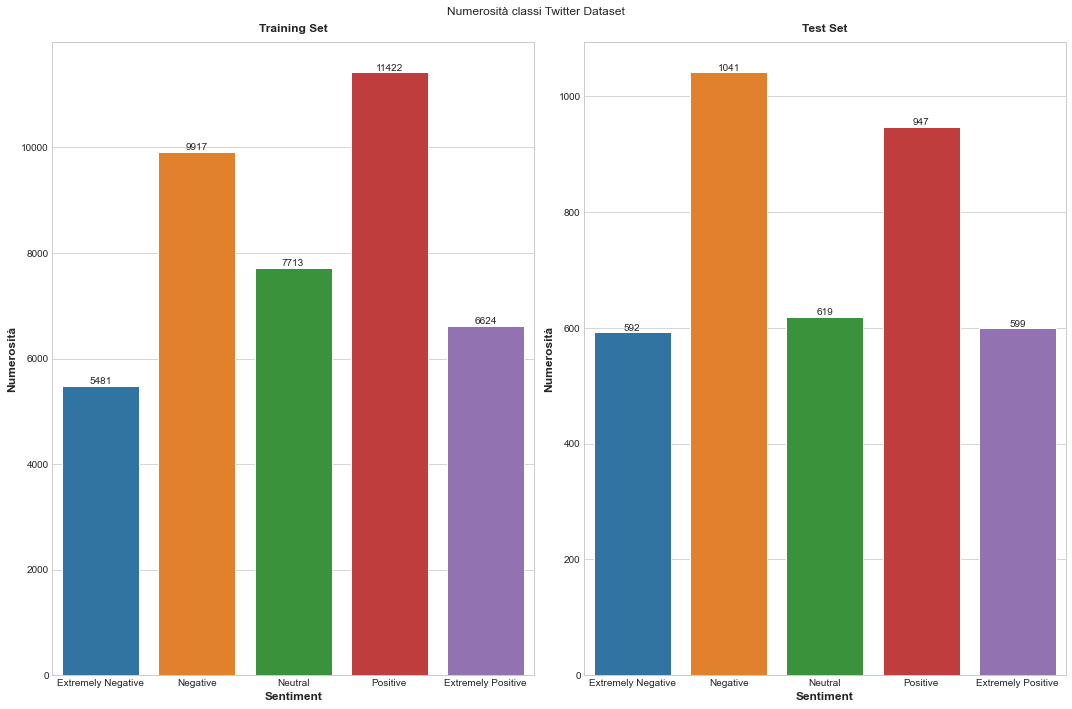

In [9]:
order = ['Extremely Negative', 'Negative', 'Neutral', 'Positive', 'Extremely Positive']

fig, ax = plt.subplots(1, 2, figsize=(15,10))
fig.suptitle('Numerosità classi Twitter Dataset')

sns.countplot(x='Sentiment', data=twitter_train, ax=ax[0], order=order)
ax[0].bar_label(ax[0].containers[0])
ax[0].set_title('Training Set')
ax[0].set_ylabel('Numerosità')
sns.countplot(x='Sentiment', data=twitter_test, ax=ax[1], order=order)
ax[1].bar_label(ax[1].containers[0])
ax[1].set_title('Test Set')
ax[1].set_ylabel('Numerosità')

plt.tight_layout()
plt.show()

Siccome le differenze tra le frasi da un punto di vista semantico potrebbero essere anche minime, si è deciso di andare ad accorpare le classi _'border line'_ alla loro controparte. Questo anche al fine di ottenere risultati migliori durante le fasi successive dell'analisi.

In [10]:
r = {'Extremely Negative': 'Negative', 'Extremely Positive':'Positive'}

twitter_train['Sentiment'] = twitter_train['Sentiment'].replace(r)
twitter_test['Sentiment'] = twitter_test['Sentiment'].replace(r)

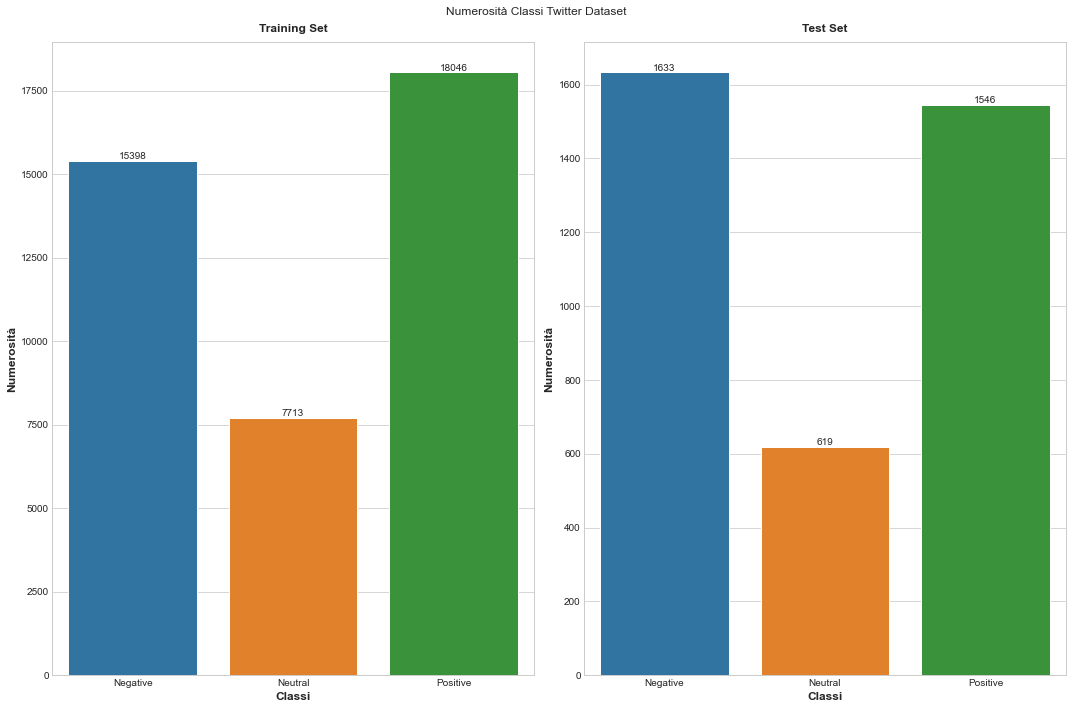

In [11]:
order = ['Negative', 'Neutral', 'Positive']

fig, ax = plt.subplots(1, 2, figsize=(15,10))
fig.suptitle('Numerosità Classi Twitter Dataset')

sns.countplot(x='Sentiment', data=twitter_train, ax=ax[0], order=order)
ax[0].bar_label(ax[0].containers[0])
ax[0].set_title('Training Set')
ax[0].set_ylabel('Numerosità')
ax[0].set_xlabel('Classi')
sns.countplot(x='Sentiment', data=twitter_test, ax=ax[1], order=order)
ax[1].bar_label(ax[1].containers[0])
ax[1].set_title('Test Set')
ax[1].set_ylabel('Numerosità')
ax[1].set_xlabel('Classi')

plt.tight_layout()
plt.show()

Nonostante l'accorpamento delle varie etichette di classe omonime, il dataset risulta comunque essere abbastanza sbilanciato. Questo potrebbe causare un peggioramento delle prestazioni dei modelli, alcune possibili e facili strategie per poter trattare il seguente problema potrebbero essere l'applicazione di tecniche di over/under sampling degli elementi delle classi.

Prima di addentrarci maggiormente nell'esplorazione e visualizzazione del dataset, si vanno ad applicare i metodi di pulizia definiti precedentemente: importante è il fatto che si andranno a rimuovere le _stopwords_ unicamente per poter visualizzare correttamente in seguito le parole più frequenti (senza avere un _bias_ dovuto alla presenza di tali parole frequenti ma semanticamente poco importanti). Mentre si manterranno nel testo che si andrà a dare in input all'architettura __BERT__ per avere maggiori informazioni di contesto. Per lo stesso motivo non si andranno ad effettuare neanche le operazioni di _stemming_ e _lemmatization_.

In [12]:
twitter_train['CleanTweet'] = twitter_train['OriginalTweet'].apply(lambda x: rimuovi_spazi(clean(rimuovi_emoji(x))))
twitter_test['CleanTweet'] = twitter_test['OriginalTweet'].apply(lambda x: rimuovi_spazi(clean(rimuovi_emoji(x))))

twitter_train['NoStopWords'] = twitter_train['CleanTweet'].apply(lambda x: rimuovi_stopwords(x))
twitter_test['NoStopWords'] = twitter_test['CleanTweet'].apply(lambda x: rimuovi_stopwords(x))

print('Twitter DS:> Esempi puliti Training Set')
display(twitter_train[['OriginalTweet', 'CleanTweet', 'NoStopWords']].iloc[10:16])
print('Twitter DS:> Esempi puliti Test Set')
display(twitter_test[['OriginalTweet', 'CleanTweet', 'NoStopWords']].iloc[10:16])

Twitter DS:> Esempi puliti Training Set


OriginalTweet  \
10  All month there hasn't been crowding in the su...   
11  Due to the Covid-19 situation, we have increas...   
12  #horningsea is a caring community. LetÂs ALL ...   
13  Me: I don't need to stock up on food, I'll jus...   
14  ADARA Releases COVID-19 Resource Center for Tr...   
15  Lines at the grocery store have been unpredict...   

                                           CleanTweet  \
10  all month there hasnt been crowding in the sup...   
11  due to the covid situation we have increased d...   
12  horningsea is a caring community let s all loo...   
13  me i dont need to stock up on food ill just ha...   
14  adara releases covid resource center for trave...   
15  lines at the grocery store have been unpredict...   

                                          NoStopWords  
10  month crowding supermarkets restaurants reduci...  
11  covid situation increased demand food products...  
12  horningsea caring community let s look capable...  
13  dont need stock food ill amazon deliver need c...  
14  adara releases covid resource center travel br...  
15  lines grocery store unpredictable eating safe ...

Twitter DS:> Esempi puliti Test Set


OriginalTweet  \
10  Best quality couches at unbelievably low price...   
11  Beware of counterfeits trying to sell fake mas...   
12  Panic food buying in Germany due to #coronavir...   
13  #Covid_19 Went to the Grocery Store, turns out...   
14  While we were busy watching election returns a...   
15  #AirSewa \r\r\n\r\r\n@flyspicejet is not provi...   

                                           CleanTweet  \
10  best quality couches at unbelievably low price...   
11  beware of counterfeits trying to sell fake mas...   
12  panic food buying in germany due to coronaviru...   
13  covid went to the grocery store turns out all ...   
14  while we were busy watching election returns a...   
15  airsewa is not providing webchecin customers f...   

                                          NoStopWords  
10  best quality couches unbelievably low prices a...  
11  beware counterfeits trying sell fake masks che...  
12  panic food buying germany coronavirus begun or...  
13  covid went grocery store turns cleaning suppli...  
14  busy watching election returns bracing covid o...  
15  airsewa providing webchecin customers free sea...

Vado nuovamente a controllare se, dopo le precedenti operazioni, sono ora presenti dei duplicati all'interno dei dati. Questo potrebbe essere dovuto alla presenza di tweet dal punto di vista contenutistico identici, ma precedentemente non rivelati come duplicati per via della presenza di hashtag, menzioni ad utenti, punteggiatura ecc.

In [13]:
train_dupl = twitter_train.duplicated(subset=['CleanTweet', 'Sentiment']).sum()
test_dupl = twitter_test.duplicated(subset=['CleanTweet', 'Sentiment']).sum()

print('Twitter DS:> Numero di duplicati presenti nel training set dopo le operazioni di pulizia del testo {};'.format(train_dupl))
print('Twitter DS:> Numero di duplicati presenti nel test set dopo le operazioni di pulizia del testo {};\n'.format(test_dupl))

Twitter DS:> Numero di duplicati presenti nel training set dopo le operazioni di pulizia del testo 213;
Twitter DS:> Numero di duplicati presenti nel test set dopo le operazioni di pulizia del testo 8;



Siccome sono stati ora trovati dei record duplicati, provvedo alla loro eliminazione:

In [14]:
mask_train = twitter_train.duplicated(subset=['CleanTweet', 'Sentiment']) # maschera in cui ho True gli elementi che sono duplicati
mask_test = twitter_test.duplicated(subset=['CleanTweet', 'Sentiment'])

twitter_train = twitter_train[~mask_train] # sintassi che mi permette di invertire i valori della maschera
twitter_test = twitter_test[~mask_test]

train_dupl = twitter_train.duplicated(subset=['CleanTweet', 'Sentiment']).sum()
test_dupl = twitter_test.duplicated(subset=['CleanTweet', 'Sentiment']).sum()

print('Twitter DS:> Numero di duplicati presenti nel training set dopo la rimozione {};'.format(train_dupl))
print('Twitter DS:> Numero di duplicati presenti nel test set dopo la rimozione {};\n'.format(test_dupl))
print('Twitter DS:> Numero di elementi nel trainig set dopo la rimozione {};'.format(twitter_train.shape[0]))
print('Twitter DS:> Numero di elementi nel test set dopo la rimozione {};'.format(twitter_test.shape[0]))

Twitter DS:> Numero di duplicati presenti nel training set dopo la rimozione 0;
Twitter DS:> Numero di duplicati presenti nel test set dopo la rimozione 0;

Twitter DS:> Numero di elementi nel trainig set dopo la rimozione 40944;
Twitter DS:> Numero di elementi nel test set dopo la rimozione 3790;


Si può quindi procedere andando a visualizzare informazioni relative al dataset su cui è stata effettuata una prima fase di pulizia.

Statistice sulla lunghezza dei Tweet nei due dataset:


mean        std  min  max  median   %25   %75   %90
Tweet Training Set  29.226334  11.661009    0   64    30.0  20.0  39.0  44.0
Tweet Test Set      32.031662  11.942019    0   62    33.0  23.0  42.0  47.0

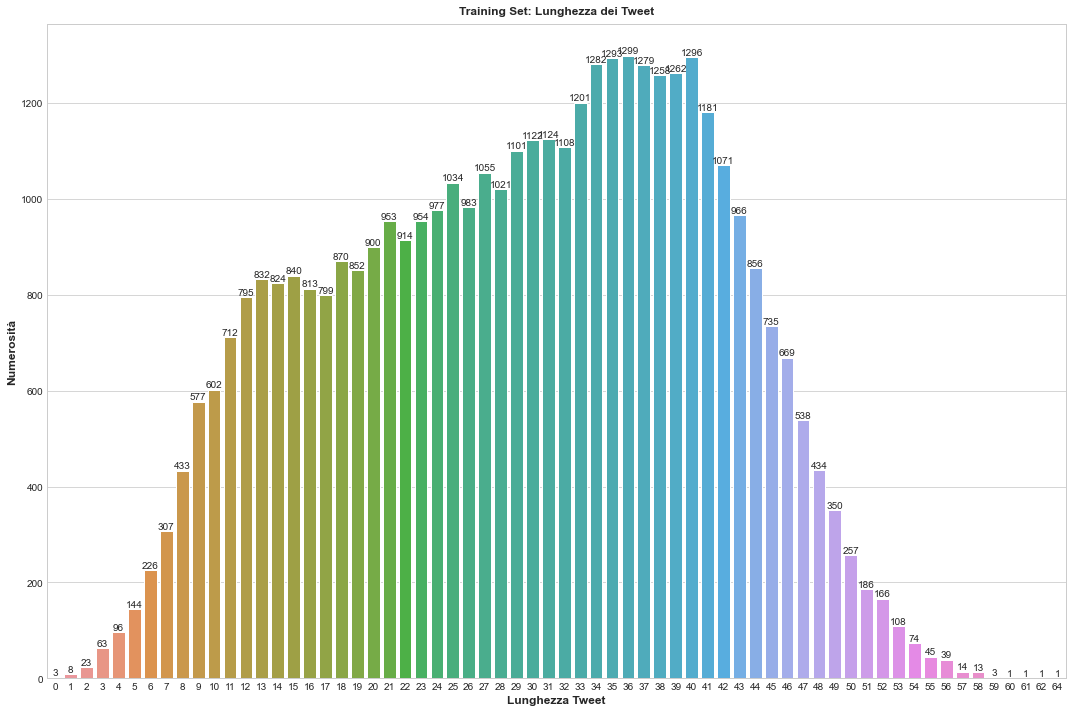

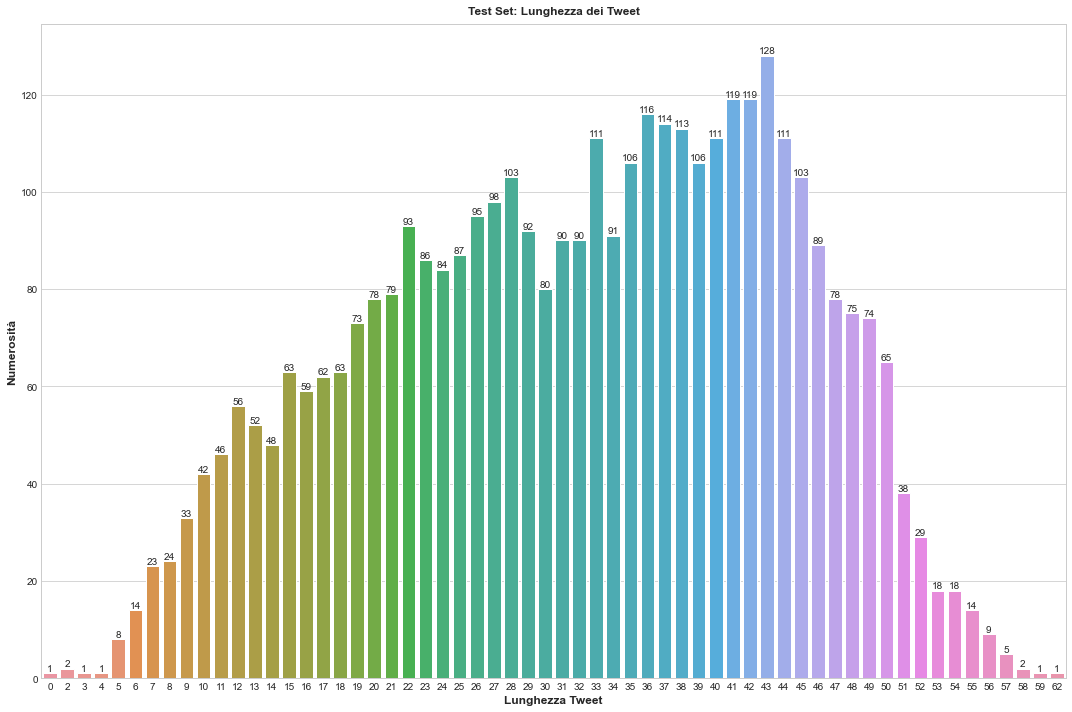

In [15]:
twitter_train['LenTweet'] = twitter_train['CleanTweet'].apply(lambda x: len(x.split()))
twitter_test['LenTweet'] = twitter_test['CleanTweet'].apply(lambda x: len(x.split()))

metriche = pd.DataFrame({'mean': [twitter_train['LenTweet'].mean(), twitter_test['LenTweet'].mean()],
                         'std': [twitter_train['LenTweet'].std(), twitter_test['LenTweet'].std()],
                         'min': [twitter_train['LenTweet'].min(), twitter_test['LenTweet'].min()],
                         'max': [twitter_train['LenTweet'].max(), twitter_test['LenTweet'].max()],
                         'median': [twitter_train['LenTweet'].median(), twitter_test['LenTweet'].median()],
                         '%25': [twitter_train['LenTweet'].quantile(.25), twitter_test['LenTweet'].quantile(.25)],
                         '%75': [twitter_train['LenTweet'].quantile(.75), twitter_test['LenTweet'].quantile(.75)],
                         '%90': [twitter_train['LenTweet'].quantile(.9), twitter_test['LenTweet'].quantile(.9)]
                        }, index=['Tweet Training Set', 'Tweet Test Set'])

print('Statistice sulla lunghezza dei Tweet nei due dataset:')
display(metriche)

fig = plt.figure(figsize=(15,10))
plt.title('Training Set: Lunghezza dei Tweet')
ax = sns.countplot(x='LenTweet', data=twitter_train)
ax.bar_label(ax.containers[0])
plt.xlabel('Lunghezza Tweet')
plt.ylabel('Numerosità')
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(15,10))
plt.title('Test Set: Lunghezza dei Tweet')
ax = sns.countplot(x='LenTweet', data=twitter_test)
ax.bar_label(ax.containers[0])
plt.xlabel('Lunghezza Tweet')
plt.ylabel('Numerosità')
plt.tight_layout()
plt.show()

A fronte delle operazioni precedentemente svolte, si può vedere come siano ora presenti tweet con zero elementi, o comunque un numero molto basso di parole. Al fine di ottenere risultati soddisfacenti si vanno ad escludere dagli insiemi di dati i record che hanno un numero minore a 4 parole.

Twitter DS:> Numero di elementi nel trainig set dopo la rimozione 40847;
Twitter DS:> Numero di elementi nel test set dopo la rimozione 3786;


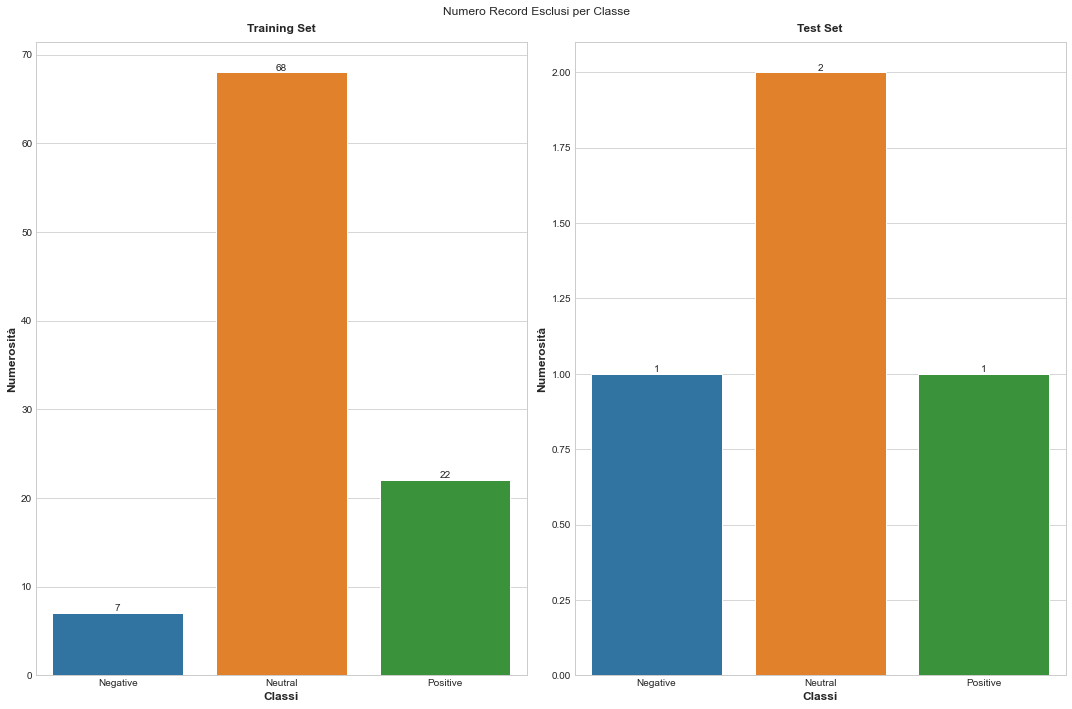

In [16]:
summary_train = twitter_train[twitter_train['LenTweet']<=3]
summary_test = twitter_test[twitter_test['LenTweet']<=3]


twitter_train = twitter_train[twitter_train['LenTweet']>3]
twitter_test = twitter_test[twitter_test['LenTweet']>3]

print('Twitter DS:> Numero di elementi nel trainig set dopo la rimozione {};'.format(twitter_train.shape[0]))
print('Twitter DS:> Numero di elementi nel test set dopo la rimozione {};'.format(twitter_test.shape[0]))

order = ['Negative', 'Neutral', 'Positive']

fig, ax = plt.subplots(1, 2, figsize=(15,10))
fig.suptitle('Numero Record Esclusi per Classe')

sns.countplot(x='Sentiment', data=summary_train, ax=ax[0], order=order)
ax[0].bar_label(ax[0].containers[0])
ax[0].set_title('Training Set')
ax[0].set_ylabel('Numerosità')
ax[0].set_xlabel('Classi')
sns.countplot(x='Sentiment', data=summary_test, ax=ax[1], order=order)
ax[1].bar_label(ax[1].containers[0])
ax[1].set_title('Test Set')
ax[1].set_ylabel('Numerosità')
ax[1].set_xlabel('Classi')

plt.tight_layout()
plt.show()

Come era prevedibile, la classe in cui compaiono il maggior numero di tweet con meno di 3 parole è quella relativa al sentiment _'Neutral'_:

In [17]:
print('Esempi di tweet eliminati:')
summary_train['OriginalTweet'].head(5)

Esempi di tweet eliminati:


0      @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...
16     ????? ????? ????? ????? ??\r\r\n?????? ????? ?...
155                 Cleanshelf supermarket Sanitizers 19
397    ??????? ???? ???? ??? ??? ???? ??? ????? ?????...
602           this is kind \r\r\nhttps://t.co/QoXqJDbLiC
Name: OriginalTweet, dtype: object

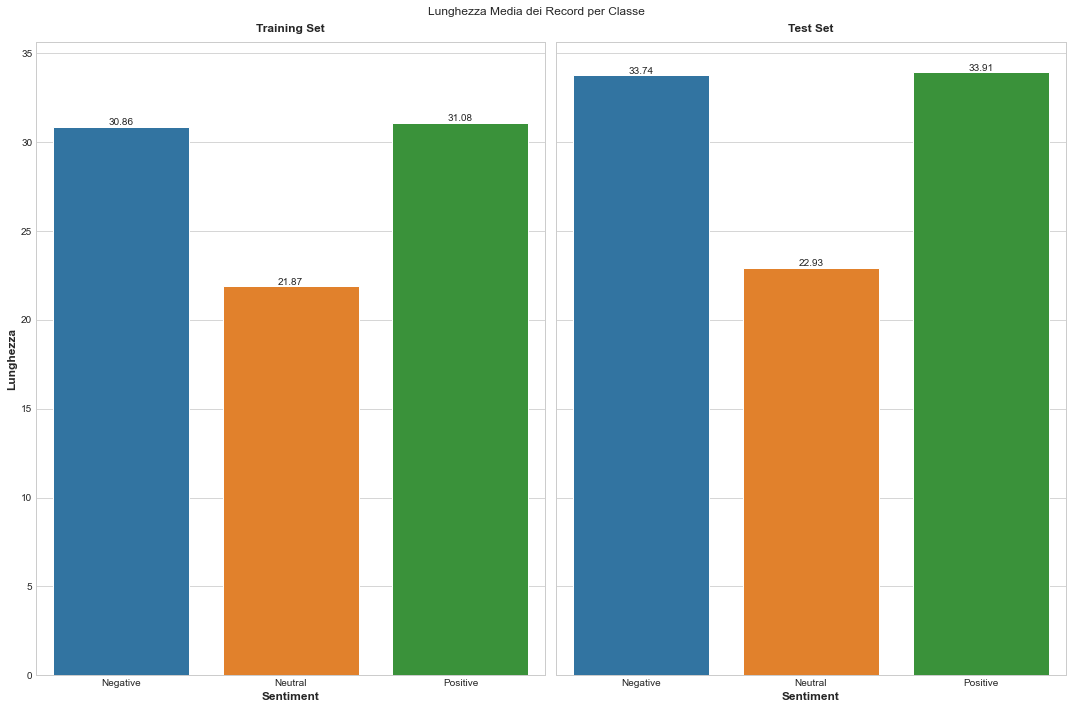

In [18]:
gb_train = twitter_train.groupby('Sentiment')['LenTweet'].mean().round(2)
gb_test = twitter_test.groupby('Sentiment')['LenTweet'].mean().round(2)

fig, ax = plt.subplots(1, 2, figsize=(15,10), sharey=True)
fig.suptitle('Lunghezza Media dei Record per Classe')

sns.barplot(x=gb_train.index, y=gb_train.values, ax=ax[0])
ax[0].set_title('Training Set')
ax[0].bar_label(ax[0].containers[0])
ax[0].set_ylabel('Lunghezza')
sns.barplot(x=gb_test.index, y=gb_test.values, ax=ax[1])
ax[1].set_title('Test Set')
ax[1].bar_label(ax[1].containers[0])

plt.tight_layout()
plt.show()

Si può inoltre notare come sempre la classe _'Neutral'_ è quella in cui compaiono, seppur di poco, i tweet con la lunghezza media inferiore. Andiamo ora ad analizzazare quali sono le parole maggiormente frequenti nel training set rispetto alle varie etichette di classe:

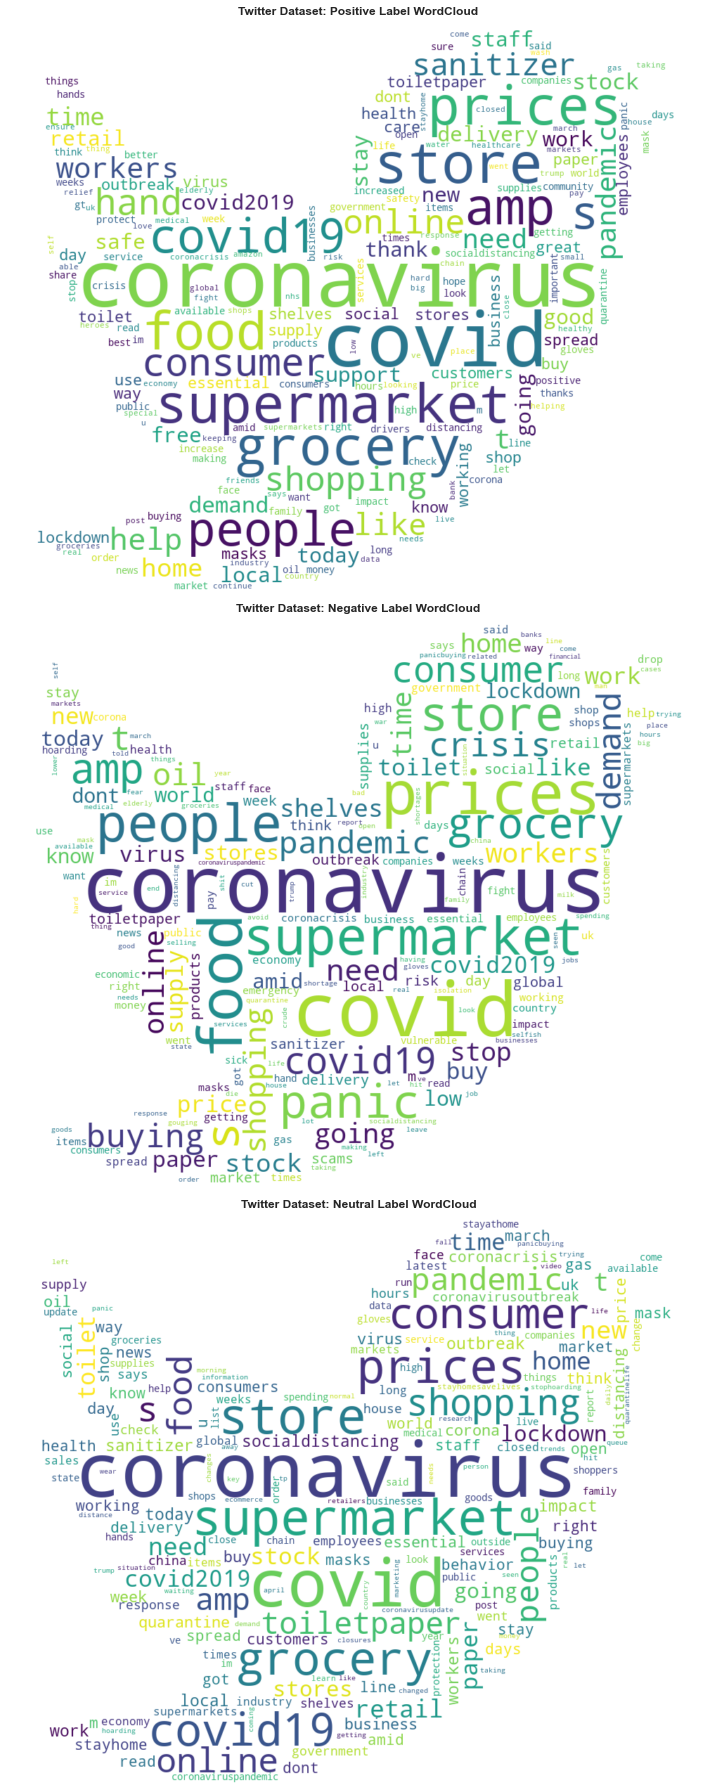

In [19]:
generate_cloud(twitter_train, 'Twitter Dataset', mask=np.array(Image.open(r'.\image\twitter_mask.png')))

Si mostrano ora i top 50  _bigrammi_ e _trigrammi_ di parole più frequenti nel testo, per tale analisi scelta progettuale è stata quella di impiegare i tweet in cui sono presenti le stopwords, al fine di riuscire meglio ad intuire l'ipotetico contesto della frase, siccome tali dati saranno anche il punto di partenza per la costruzione dell'input da dare in pasto al modello successivamente.

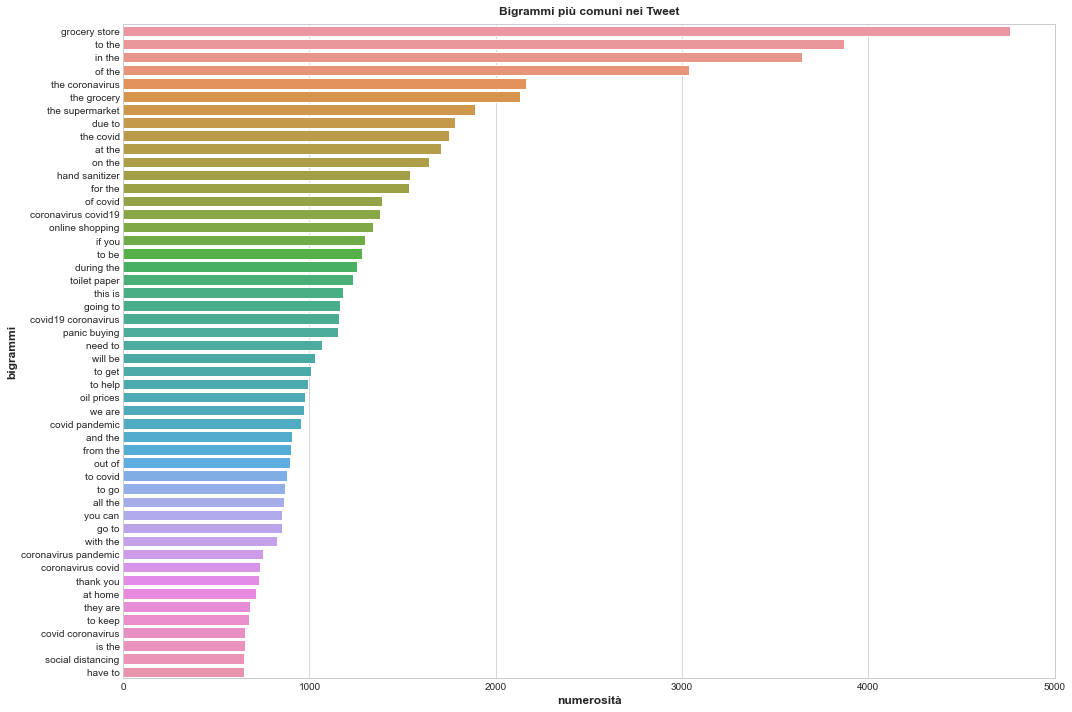

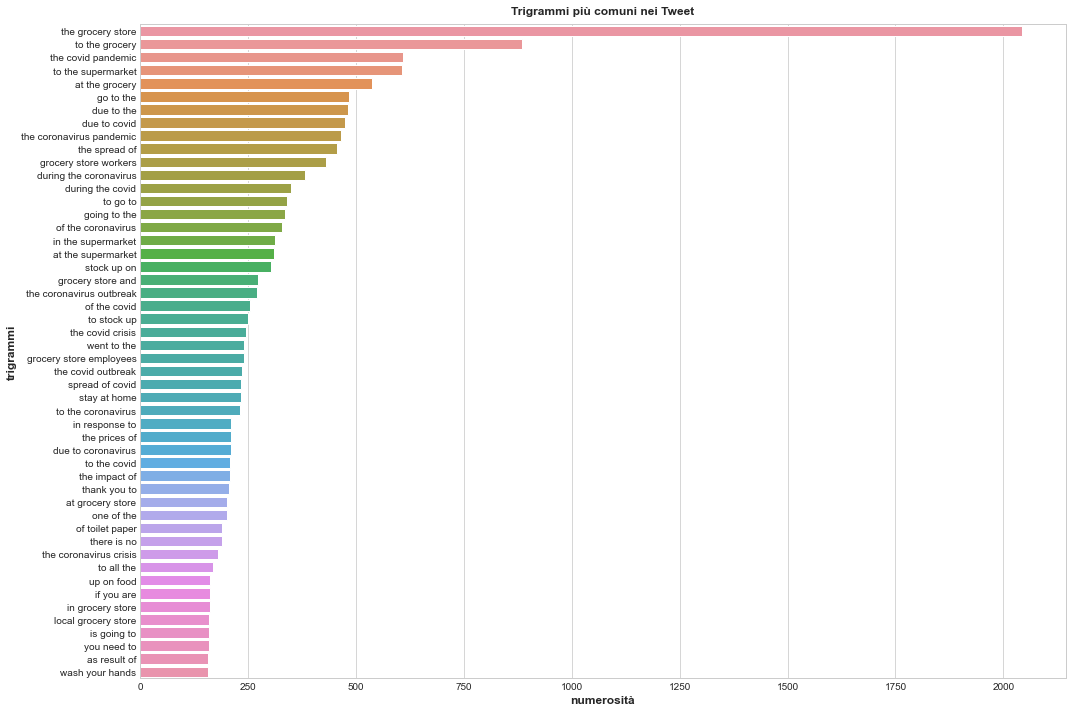

In [20]:
bigram = get_top_ngrams(twitter_train['CleanTweet'], 50, 2)
trigram = get_top_ngrams(twitter_train['CleanTweet'], 50, 3)

plt.figure(figsize=(15,10))
p = sns.barplot(y = bigram.index, x = bigram['count'].values)
plt.title("Bigrammi più comuni nei Tweet")
plt.xlabel("numerosità")
plt.ylabel("bigrammi")
plt.tight_layout()
plt.show()

plt.figure(figsize=(15,10))
p = sns.barplot(y = trigram.index, x = trigram['count'].values)
plt.title("Trigrammi più comuni nei Tweet")
plt.xlabel("numerosità")
plt.ylabel("trigrammi")
plt.tight_layout()
plt.show()

Da notare che, soprattutto tra i bigrammi, spesso compaiono raggruppamenti di elementi frequenti che con molta probabilità corrispondevano originariamente ad hashtag (esempio: coronavirus-covid, covid19-coronavirus).

Si può inoltre osservare dai grafici di cui sopra il contesto specifico di tale dataset di tweet, ossia l'epidemia di Corona Virus. Infatti i termini 'covid' e 'coronavirus' sono presenti in gran misura nei documenti a prescindere dall'etichetta che si prende in considerazione, e ovviamente questi si incontrano frequentemente anche nell'analisi dei bigrammi e trigrammi. Tali parole saranno quindi importanti ai fini dell'impiego dell'architettura transformers __BERT__, poichè strettamente legate al contesto semantico dei dati.

In [21]:
bert_tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [22]:
encoded = bert_tokenizer.encode(twitter_train.iloc[40]['CleanTweet'])
decoded = bert_tokenizer.decode(encoded)

print('Twitter DS:> Esempio di Tokenizzazione... \n')
print(encoded,'\n')
print(decoded)

Twitter DS:> Esempio di Tokenizzazione... 

[101, 4638, 2678, 2053, 2833, 1999, 3915, 3006, 2349, 2000, 21887, 23350, 6634, 2057, 6069, 3280, 2013, 22611, 21887, 23350, 5833, 23890, 21887, 23350, 5395, 2053, 14876, 7716, 2025, 10448, 7485, 23298, 2053, 11774, 7377, 9681, 2053, 11774, 8791, 25090, 6290, 2522, 17258, 16147, 6090, 3207, 7712, 2561, 7878, 7698, 2522, 17258, 11387, 16147, 10383, 24547, 22345, 102] 

[CLS] check video no food in usa market due to coronavirus panic we gonna die from starvation coronavirusoutbreak coronavirus houston nofood notoiletpaper nohandshakes nohandsanitizer covid19 pandemic totallockdown covid2019usa walmart [SEP]


Come si può notare siccome __BERT__ va ad inserire anche dei caratteri speciali nel testo durante le sue operazioni di tokenizzazione, la lunghezza originale dei tweet potrebbe essere inferiore rispetto alla controparte tokenizzata. Proprio per tale motivo si va a ricercare il massimo per poter selezionare opportunamente la lunghezza dell'input da dare in pasto successivamente al modello.

In [23]:
token_len_train = twitter_train['CleanTweet'].apply(lambda x : len(bert_tokenizer.encode(x))).max()
token_len_test = twitter_test['CleanTweet'].apply(lambda x : len(bert_tokenizer.encode(x))).max()

print('Twitter DS:> Numero massimo di token ottenuti nel Training Set {}'.format(token_len_train))
print('Twitter DS:> Numero massimo di token ottenuti nel Test Set {}'.format(token_len_test))

Twitter DS:> Numero massimo di token ottenuti nel Training Set 105
Twitter DS:> Numero massimo di token ottenuti nel Test Set 97


Terminiamo quindi la fase di preprocessing, scelta progettuale è stata l'impiego della strategia _OneHotEncoding_ per la preparazione delle label di classe siccome non è presente una relazione d'ordine tra le varie etichette e perciò l'intenzione è quella di mantenerle separate agli occhi del modello. Inoltre si costruisce ulteriormente un _Validarion Set_ che si impiegherà appunto per la validazione dei risultati del modello durante la fase di addestramento.

In [24]:
X, y = twitter_train['CleanTweet'].values, twitter_train['Sentiment'].values

In [25]:
x_train_tw, x_valid_tw, y_train_tw, y_valid_tw = train_test_split(X, y, test_size=0.1, stratify=y, random_state=SEED)
x_test_tw, y_test_tw = twitter_test['CleanTweet'].values, twitter_test['Sentiment'].values

print('Twitter DS:> Numero Elementi Training Set {}'.format(x_train_tw.shape[0]))
print('Twitter DS:> Numero Elementi Validation Set {}'.format(x_valid_tw.shape[0]))
print('Twitter DS:> Numero Elementi Test Set {}'.format(x_test_tw.shape[0]))

Twitter DS:> Numero Elementi Training Set 36762
Twitter DS:> Numero Elementi Validation Set 4085
Twitter DS:> Numero Elementi Test Set 3786


Applico _OneHotEncoding_ alle etichette di classe:

In [26]:
o = OneHotEncoder()

y_train_tw = o.fit_transform(y_train_tw.reshape(-1, 1)).toarray()
y_valid_tw = o.fit_transform(y_valid_tw.reshape(-1, 1)).toarray()
y_test_tw = o.fit_transform(y_test_tw.reshape(-1, 1)).toarray()

In [27]:
print('Twitter DS:> Esempio etichette di classe post encoding')
y_train_tw

Twitter DS:> Esempio etichette di classe post encoding


array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.]])

Applico la tokenizzazione dei record tramite l'utilizzo del __BertTokenizerFast__ precedentemente definito. Si impiega come lunghezza massima dei vettori da dare in input al modello un valore pari a 128, leggermente superiore rispetto al numero massimo di token tra i record:

In [28]:
MAX_LEN = 128

In [29]:
x_train_tw_ids, x_train_tw_masks = get_token(x_train_tw, bert_tokenizer, MAX_LEN)
x_valid_tw_ids, x_valid_tw_masks = get_token(x_valid_tw, bert_tokenizer, MAX_LEN)
x_test_tw_ids, x_test_tw_masks = get_token(x_test_tw, bert_tokenizer, MAX_LEN)

In [30]:
print('Twitter DS:> Dimensione Training Set [Ids/Masks] {}/{}'.format(x_train_tw_ids.shape, x_train_tw_masks.shape))
print('Twitter DS:> Dimensione Validation Set [Ids/Masks] {}/{}'.format(x_valid_tw_ids.shape, x_valid_tw_masks.shape))
print('Twitter DS:> Dimensione Test Set [Ids/Masks] {}/{}'.format(x_test_tw_ids.shape, x_test_tw_masks.shape))

Twitter DS:> Dimensione Training Set [Ids/Masks] (36762, 128)/(36762, 128)
Twitter DS:> Dimensione Validation Set [Ids/Masks] (4085, 128)/(4085, 128)
Twitter DS:> Dimensione Test Set [Ids/Masks] (3786, 128)/(3786, 128)


In [31]:
print('Twitter DS:> Esempio Vettore di Id e Mask')
x_train_tw_ids[0], x_train_tw_masks[0]

Twitter DS:> Esempio Vettore di Id e Mask


(array([  101,  2034,  2051,  1999,  1037, 17006,  1999,  2420,  1998,
         1996, 15475,  2024,  2066,  2023, 21887, 26775, 17417,  2015,
          102,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
      

Il Tokenizzatore, per come è stato costruito, restituisce due vettori per ogni record che verranno impiegati come input. Questi sono:
>* <dt>Input Id:</dt>
><dd>Indici delle parole all'interno del vocabolario impiegato dal tokenizer pretrained, secondo la forma in cui le aspetta il layer di embedding BERT.</dd>
>* <dt>Attention Mask:</dt>
><dd>Vettore che identifica al layer di embedding BERT quali sono i valori dell'input che corrispondono ad elementi inseriti per via dell'operazione di padding (valori posti a zero).</dd>

In [32]:
# salvo il training e test set per utilizzarli successivamente nell'appendice senza dover ripetere tutte le op di preproc

exists = os.path.isfile(os.path.join(PREPROC_DIR, 'twitter_train.csv'))
if not exists:
    twitter_train[['CleanTweet', 'Sentiment']].to_csv(os.path.join(PREPROC_DIR, 'twitter_train.csv'), index=False)
        
exists = os.path.isfile(os.path.join(PREPROC_DIR, 'twitter_test.csv'))
if not exists:
    twitter_test[['CleanTweet', 'Sentiment']].to_csv(os.path.join(PREPROC_DIR, 'twitter_test.csv'), index=False)

<img src="image/imdb_logo.png" width="150" height="150" align="right"/>

## IMDB Dataset

Si procede nell'analisi andando ora a trattare l' __IMDB Dataset__, questo contiene dati estratti dal noto sito web IMDb in cui gli utenti possono scrivere recensioni in merito a programmi televisivi e film. In particolare, le informazioni in nostro possesso sono relative alle suddette recensioni, a cui è associata una label di classe in base al _sentiment_ del testo.

Si sottolinea inoltre il fatto che per il seguente dataset abbiamo a disposizione una collezione unica di documenti da cui si dovranno necessariamente estrarre gli insiemi di _train_, _test_ e _validation_.

In [33]:
print('IMDB DS:> Numero di elementi {};'.format(imdb_ds.shape[0]))

IMDB DS:> Numero di elementi 50000;


In [34]:
print('Esempi di Record:')
display(imdb_ds.head(10))

Esempi di Record:


review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
5  Probably my all-time favorite movie, a story o...  positive
6  I sure would like to see a resurrection of a u...  positive
7  This show was an amazing, fresh & innovative i...  negative
8  Encouraged by the positive comments about this...  negative
9  If you like original gut wrenching laughter yo...  positive

A differenza del dataset precedente, in questo caso abbiamo a disposizione solamente due colonne che rappresentano le informazioni necessarie di cui abbiamo bisogno per l'analisi. Si procede andando a modificare il nome di tali attributi, questo viene fatto semplicemente per facilità di scrittura, andando a seguire lo standard incontrato nel __Twitter Dataset__.

In [35]:
c = {'review': 'OriginalReview', 'sentiment': 'Sentiment'}
imdb_ds = imdb_ds.rename(columns=c)

print('IMDB DS:> Nome delle features dopo la modifica {};'.format(imdb_ds.columns.to_list()))

IMDB DS:> Nome delle features dopo la modifica ['OriginalReview', 'Sentiment'];


Andiamo ora a controllare la presenza di eventuali duplicati o valori nulli:

In [36]:
num_nan = imdb_ds.isna().any().sum()
num_dupl = imdb_ds.duplicated().sum()

print('IMDB DS:> Numero di valori Null presenti {};'.format(num_nan))
print('IMDB DS:> Numero di duplicati presenti {};'.format(num_dupl))

IMDB DS:> Numero di valori Null presenti 0;
IMDB DS:> Numero di duplicati presenti 418;


Essendo presenti duplicati procediamo con la loro eliminazione:

In [37]:
mask = imdb_ds.duplicated()
imdb_ds = imdb_ds[~mask]
num_dupl = imdb_ds.duplicated().sum()

print('IMDB DS:> Numero di duplicati presenti dopo la rimozione {};'.format(num_dupl))
print('IMDB DS:> Numero di elementi dopo la rimozione {};'.format(imdb_ds.shape[0]))

IMDB DS:> Numero di duplicati presenti dopo la rimozione 0;
IMDB DS:> Numero di elementi dopo la rimozione 49582;


Si procede quindi andando ad analizzare il numero delle etichette di classe e la loro numerosità all'interno del dataset:

In [38]:
classi = imdb_ds['Sentiment'].unique()
print("IMDB DS:> Classi presenti all'interno del dataset\n\t{};".format(classi))

IMDB DS:> Classi presenti all'interno del dataset
	['positive' 'negative'];


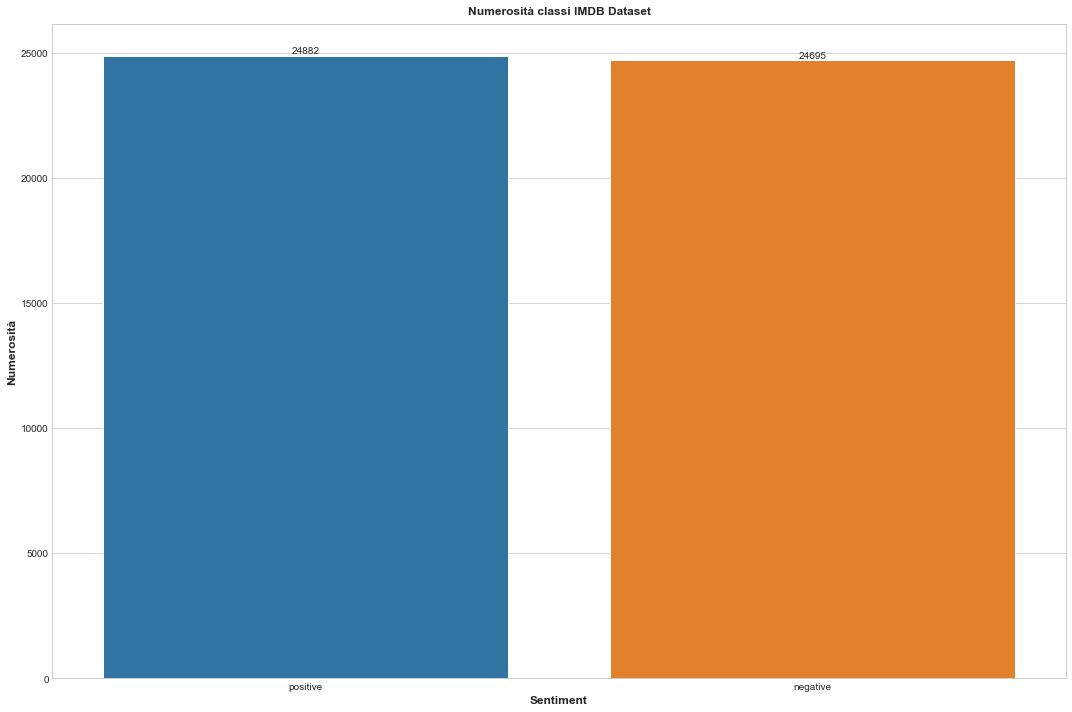

In [172]:
fig = plt.figure(figsize=(15,10))
plt.title('Numerosità classi IMDB Dataset')
ax = sns.countplot(x='Sentiment', data=imdb_ds)
ax.bar_label(ax.containers[0])
plt.ylabel('Numerosità')
plt.tight_layout()
plt.show()

Il dataset in questione risulta essere sostanzialmente bilanciato, inoltre sono presenti sole 2 etichette di classe _'positive'_ e _'negative_. Prima di procedere nella fase di visualizzazione, andiamo preventivamente ad applicare i metodi definiti per la pulizia e preprocessing iniziale del testo.

In [40]:
imdb_ds['CleanReview'] = imdb_ds['OriginalReview'].apply(lambda x: rimuovi_spazi(clean(rimuovi_emoji(x))))
imdb_ds['NoStopWords'] = imdb_ds['CleanReview'].apply(lambda x: rimuovi_stopwords(x))

print('IMDB DS:> Esempi di record dopo le operazioni di pulizia')
display(imdb_ds[['OriginalReview', 'CleanReview', 'NoStopWords']].iloc[10:16])

IMDB DS:> Esempi di record dopo le operazioni di pulizia


OriginalReview  \
10  Phil the Alien is one of those quirky films wh...   
11  I saw this movie when I was about 12 when it c...   
12  So im not a big fan of Boll's work but then ag...   
13  The cast played Shakespeare.<br /><br />Shakes...   
14  This a fantastic movie of three prisoners who ...   
15  Kind of drawn in by the erotic scenes, only to...   

                                          CleanReview  \
10  phil the alien is one of those quirky films wh...   
11  i saw this movie when i was about when it came...   
12  so im not a big fan of bolls work but then aga...   
13  the cast played shakespeare shakespeare lost i...   
14  this a fantastic movie of three prisoners who ...   
15  kind of drawn in by the erotic scenes only to ...   

                                          NoStopWords  
10  phil alien quirky films humour based oddness a...  
11  saw movie came recall scariest scene big bird ...  
12  im big fan bolls work enjoyed movie postal may...  
13  cast played shakespeare shakespeare lost appre...  
14  fantastic movie prisoners famous actors george...  
15  kind drawn erotic scenes realize amateurish un...

Controlliamo nuovamente se a fronte delle operazioni di pulizia non siano ora presenti nuovamente record duplicati:

In [41]:
num_dupl = imdb_ds.duplicated(subset=['CleanReview', 'Sentiment']).sum()

print('IMDB DS:> Numero di duplicati presenti dopo le operazioni di pulizia del testo {};'.format(num_dupl))

IMDB DS:> Numero di duplicati presenti dopo le operazioni di pulizia del testo 5;


In [42]:
mask = imdb_ds.duplicated(subset=['CleanReview', 'Sentiment'], keep=False)
imdb_ds[mask][['OriginalReview', 'CleanReview', 'Sentiment']].sort_values(by='OriginalReview')

OriginalReview  \
23900  Ah yet another Seagal movie.In no less than a ...   
13499  Ah yet another Seagal movie.In no less than a ...   
26213  Having the opportunity to watch some of the fi...   
32051  Having the opportunity to watch some of the fi...   
48097  How Tasty Was My Little Frenchman tells a stor...   
27916  How Tasty Was My Little Frenchman tells a stor...   
27528  This is yet another pseudo-intellectual "let's...   
13610  This is yet another pseudo-intellectual "let's...   
44855  This movie got off to an interesting start. Do...   
14559  This movie got off to an interesting start. Do...   

                                             CleanReview Sentiment  
23900  ah yet another seagal movie in no less than a ...  negative  
13499  ah yet another seagal movie in no less than a ...  negative  
26213  having the opportunity to watch some of the fi...  positive  
32051  having the opportunity to watch some of the fi...  positive  
48097  how tasty was my little frenchman tells a stor...  positive  
27916  how tasty was my little frenchman tells a stor...  positive  
27528  this is yet another pseudo intellectual lets m...  negative  
13610  this is yet another pseudo intellectual lets m...  negative  
44855  this movie got off to an interesting start dow...  negative  
14559  this movie got off to an interesting start dow...  negative

Provvedo all'eliminazione di tali duplicati:

In [43]:
mask = imdb_ds.duplicated(subset=['CleanReview', 'Sentiment'])
imdb_ds = imdb_ds[~mask]
num_dupl = imdb_ds.duplicated(subset=['CleanReview', 'Sentiment']).sum()

print('IMDB DS:> Numero di duplicati presenti nel training set dopo la rimozione {};'.format(num_dupl))
print('IMDB DS:> Numero di elementi nel trainig set dopo la rimozione {};'.format(imdb_ds.shape[0]))

IMDB DS:> Numero di duplicati presenti nel training set dopo la rimozione 0;
IMDB DS:> Numero di elementi nel trainig set dopo la rimozione 49577;


Si procede andando a mostrare alcune metriche statistiche relative alla lunghezza dei testi:

In [44]:
imdb_ds['LenReview'] = imdb_ds['CleanReview'].apply(lambda x: len(x.split()))

metriche = pd.DataFrame({'mean': imdb_ds['LenReview'].mean(),
                         'std': imdb_ds['LenReview'].std(),
                         'min': imdb_ds['LenReview'].min(),
                         'max': imdb_ds['LenReview'].max(),
                         'median': imdb_ds['LenReview'].median(),
                         '%25': imdb_ds['LenReview'].quantile(.25),
                         '%75': imdb_ds['LenReview'].quantile(.75),
                         '%90': imdb_ds['LenReview'].quantile(.9),
                        }, index=['IMDB Data Set'])

print('Statistice sulla lunghezza delle recensioni nel dataset:')
display(metriche)

Statistice sulla lunghezza delle recensioni nel dataset:


mean         std  min   max  median    %25    %75    %90
IMDB Data Set  229.836255  170.292868    6  2453   172.0  126.0  279.0  449.0

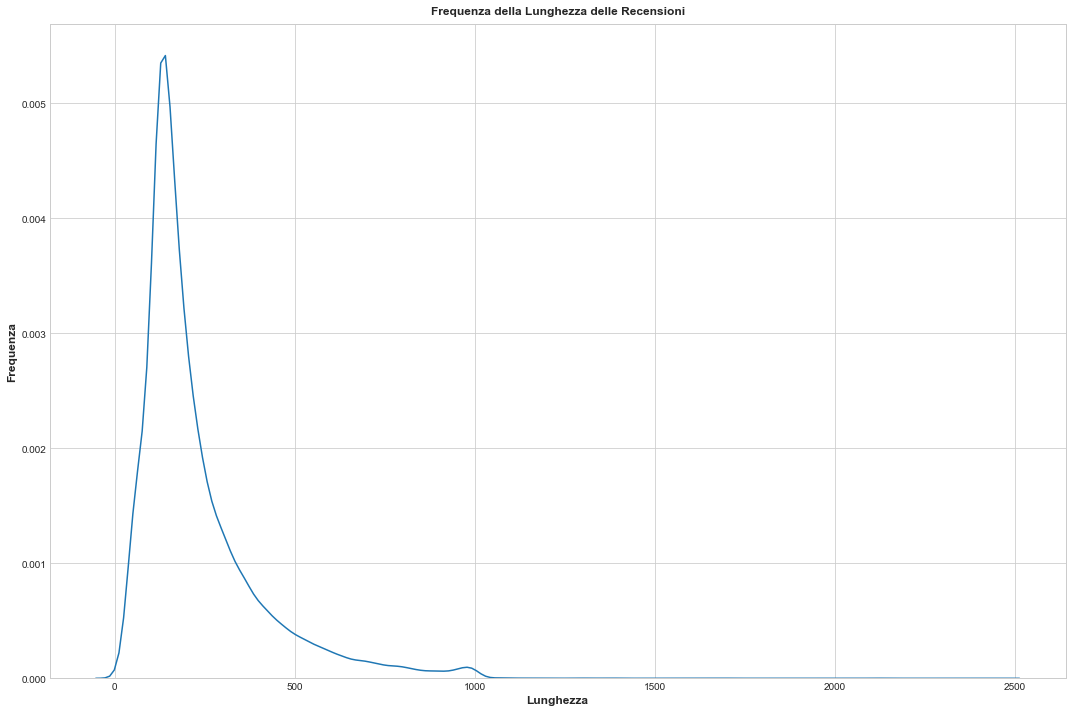

In [45]:
fig = plt.figure(figsize=(15,10))
plt.title('Frequenza della Lunghezza delle Recensioni')
ax = sns.kdeplot(x='LenReview', data=imdb_ds)
plt.xlabel('Lunghezza')
plt.ylabel('Frequenza')
plt.tight_layout()
plt.show()

Il seguente dataset risulta costituito da un numero relativamente basso di recensioni aventi oltre 500 parole. Ovviamente è improponibile andare a lavorare con tali numeri, anche considerando il fatto che la dimensione massima accettata dal modello __BERT__ è pari a 512. Si può quindi scegliere un valore di lunghezza massima dell'input del modello pari a 450 (90-esimo percentile), siccome meno del 10% dei record avrà lunghezza superiore a tale soglia. Inoltre il minimo numero di token risulta essere pari a 6, si possono quindi evitare di eliminare tali record. Si sottolinea il fatto che tale dataset è quello che in generale sarà costituito dai documenti più lunghi tra le tre collezioni.

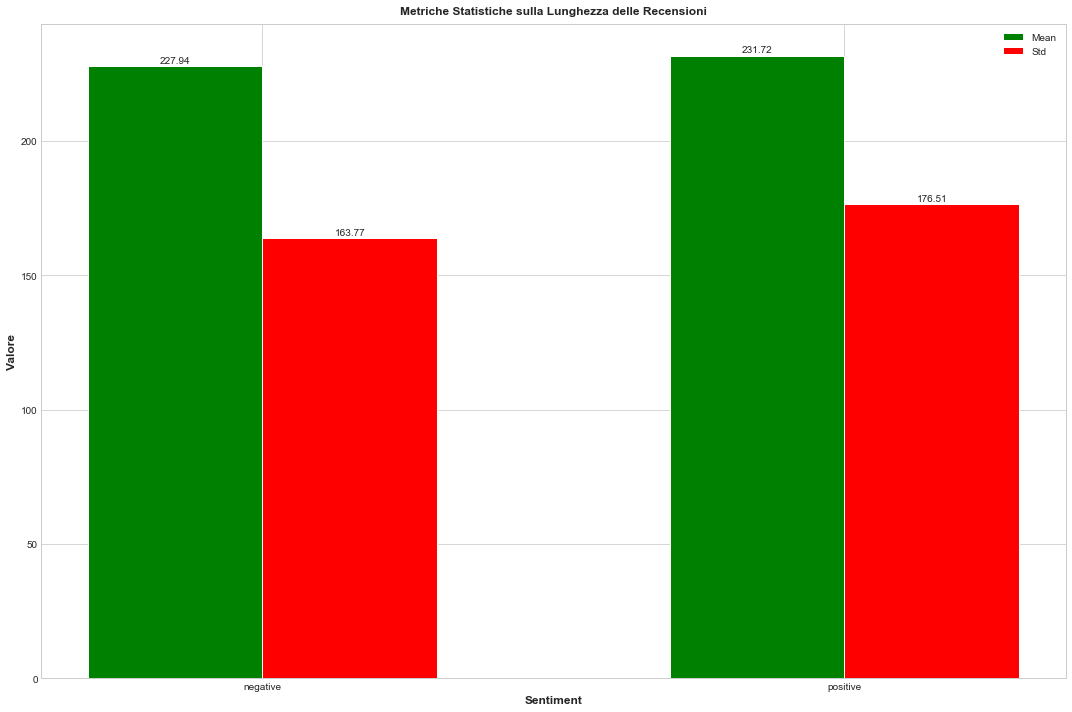

In [46]:
gb_mean = imdb_ds.groupby('Sentiment')['LenReview'].mean().round(2)
gb_std = imdb_ds.groupby('Sentiment')['LenReview'].std().round(2)

fig = plt.figure(figsize=(15, 10))
axis = fig.add_subplot(111)
w = 0.3
x_ticks = np.arange(2) # numero di classi
r1 = axis.bar(x_ticks-w, gb_mean.values, width=w, color='g', align='edge', label='Mean')
r2 = axis.bar(x_ticks, gb_std.values, width=w, color='r', align='edge', label='Std')
axis.set_title('Metriche Statistiche sulla Lunghezza delle Recensioni')
axis.set_ylabel('Valore')
axis.set_xlabel('Sentiment')
axis.set_xticks(x_ticks, ['negative', 'positive'])
axis.legend(loc='upper right')
axis.bar_label(r1, padding=1)
axis.bar_label(r2, padding=1)
fig.tight_layout()
plt.show()

Precediamo andando ad analizzare le parole maggiormente frequenti, insieme ai top bigrammi e trigrammi:

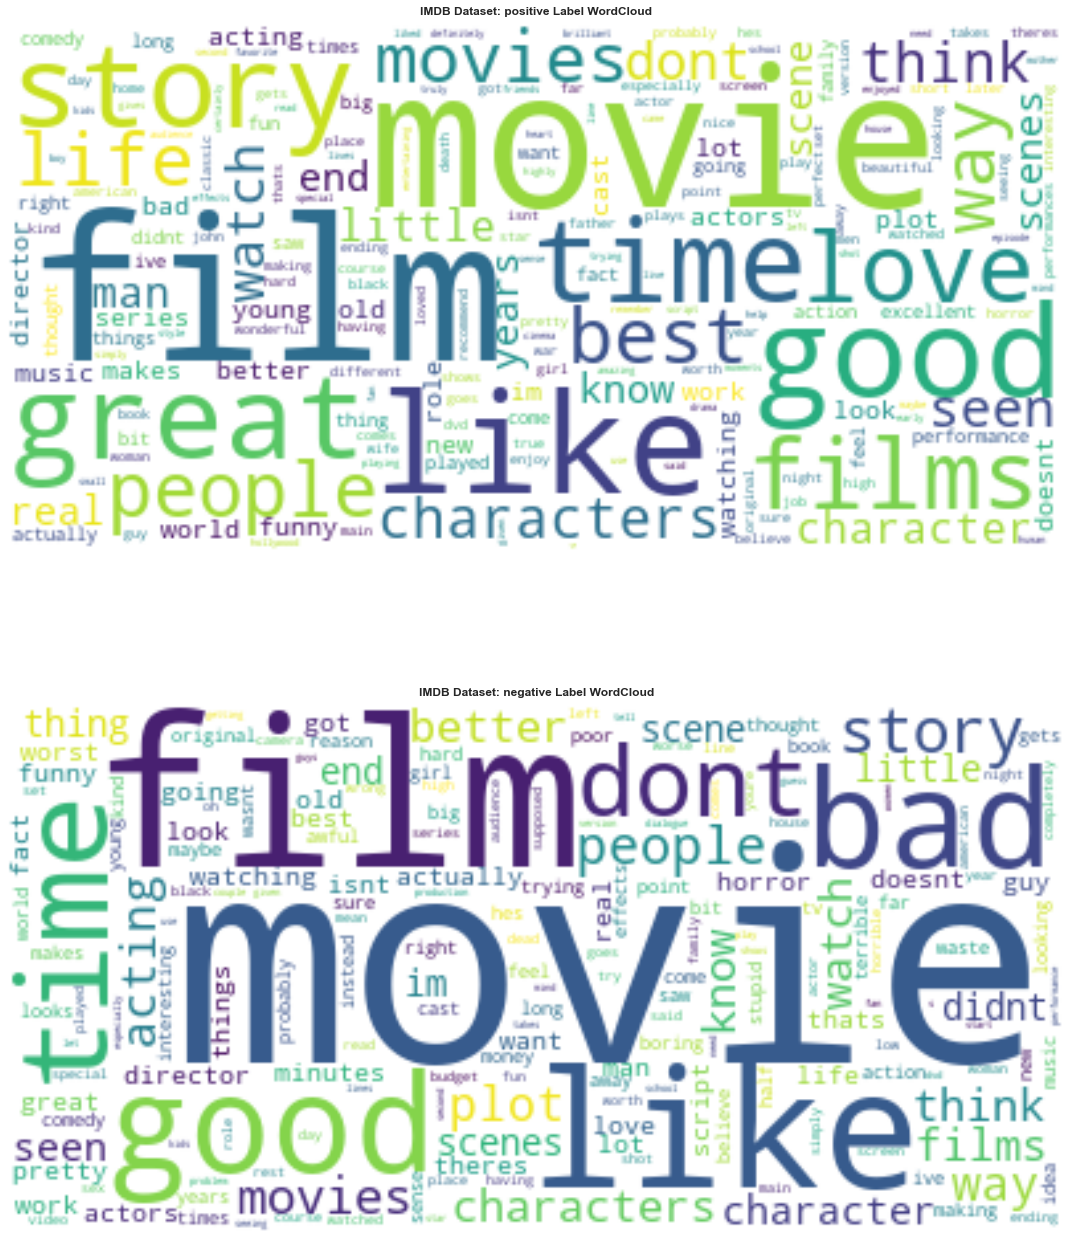

In [47]:
generate_cloud(imdb_ds, 'IMDB Dataset')

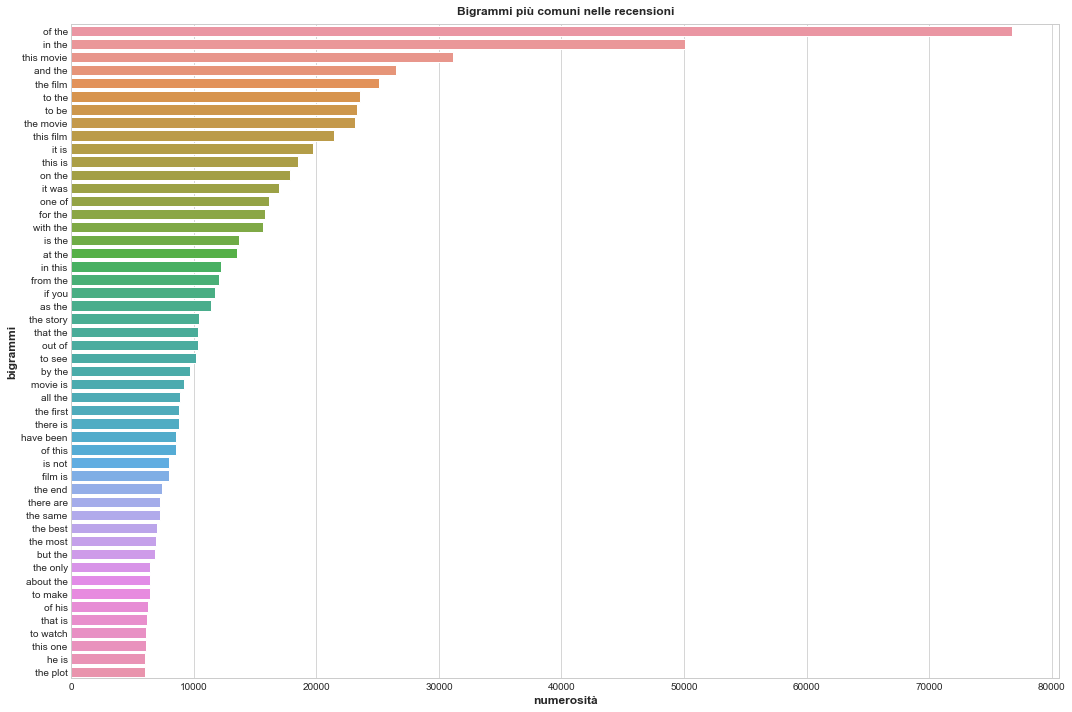

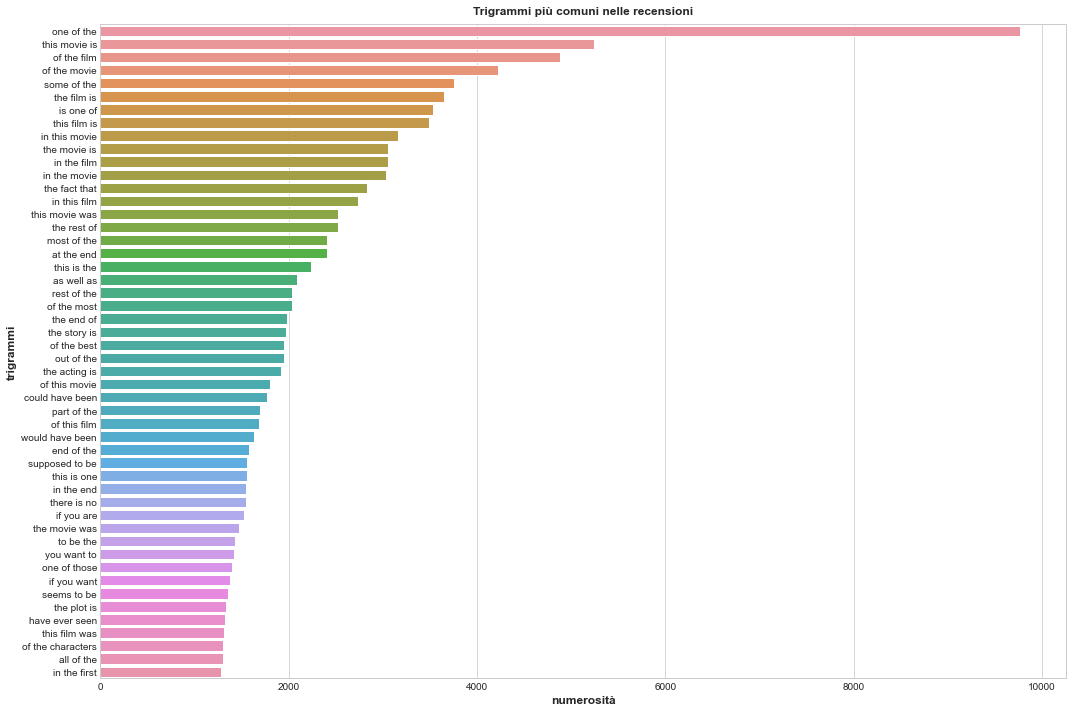

In [48]:
# slow cell

bigram = get_top_ngrams(imdb_ds['CleanReview'], 50, 2)
trigram = get_top_ngrams(imdb_ds['CleanReview'], 50, 3)

plt.figure(figsize=(15,10))
p = sns.barplot(y = bigram.index, x = bigram['count'].values)
plt.title("Bigrammi più comuni nelle recensioni")
plt.xlabel("numerosità")
plt.ylabel("bigrammi")
plt.tight_layout()
plt.show()

plt.figure(figsize=(15,10))
p = sns.barplot(y = trigram.index, x = trigram['count'].values)
plt.title("Trigrammi più comuni nelle recensioni")
plt.xlabel("numerosità")
plt.ylabel("trigrammi")
plt.tight_layout()
plt.show()

Non è difficile notare dai grafici soprastanti quale sia il contesto del seguente insieme di testi, infatti i termini quali _'movie'_ e _'film'_ risultano essere i più frequenti a prescindere dalla classe. Inoltre dall'analisi dei bigrammi e trigrammi, si può osservare una presenza maggiore di _stopwords_ rispetto al dataset precedente, dovuta molto probabilmente al fatto che la lunghezza media dei record è anch'essa superiore. 

Per concludere andiamo a terminare le operazioni di _preprocessing_, costruendo gli split di __train__, __validation__ e __test__ ed infine applicando il  __BertTokenizerFast__ per ottenere i verrori di __input_id__ e __attention_mask__ per ogni record:

In [49]:
X, y = imdb_ds['CleanReview'].values, imdb_ds['Sentiment'].values

In [50]:
X_imdb, x_valid_imdb, y_imdb, y_valid_imdb = train_test_split(X, y, test_size=0.15, stratify=y, random_state=SEED)
x_train_imdb, x_test_imdb, y_train_imdb, y_test_imdb = train_test_split(X_imdb, y_imdb, test_size=0.1, stratify=y_imdb, random_state=SEED)

print('IMDB DS:> Numero Elementi Training Set {}'.format(x_train_imdb.shape[0]))
print('IMDB DS:> Numero Elementi Validation Set {}'.format(x_valid_imdb.shape[0]))
print('IMDB DS:> Numero Elementi Test Set {}'.format(x_test_imdb.shape[0]))

IMDB DS:> Numero Elementi Training Set 37926
IMDB DS:> Numero Elementi Validation Set 7437
IMDB DS:> Numero Elementi Test Set 4214


Come nel caso precedente applico _OneHotEncoding_ alle etichette di classe:

In [51]:
o = OneHotEncoder()

y_train_imdb = o.fit_transform(y_train_imdb.reshape(-1, 1)).toarray()
y_valid_imdb = o.fit_transform(y_valid_imdb.reshape(-1, 1)).toarray()
y_test_imdb = o.fit_transform(y_test_imdb.reshape(-1, 1)).toarray()

In [52]:
print('IMDB DS:> Esempio etichette di classe post encoding')
y_train_imdb

IMDB DS:> Esempio etichette di classe post encoding


array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

Per motivi legati alla dimensione dei tensori, usare il valore 450 di lunghezza massima dell'input rende il training del modello proibitivo (in termini di memoria utilizzata), per questo motivo si seleziona la soglia 250 che risulta comunque prossima al valore del 75-esimo percentile:

In [53]:
MAX_LEN = 250

In [54]:
# impiego il bert_tokenizer definito precedentemente

x_train_imdb_ids, x_train_imdb_masks = get_token(x_train_imdb, bert_tokenizer, MAX_LEN)
x_valid_imdb_ids, x_valid_imdb_masks = get_token(x_valid_imdb, bert_tokenizer, MAX_LEN)
x_test_imdb_ids, x_test_imdb_masks = get_token(x_test_imdb, bert_tokenizer, MAX_LEN)

In [55]:
print('IMDB DS:> Dimensione Training Set [Ids/Masks] {}/{}'.format(x_train_imdb_ids.shape, x_train_imdb_masks.shape))
print('IMDB DS:> Dimensione Validation Set [Ids/Masks] {}/{}'.format(x_valid_imdb_ids.shape, x_valid_imdb_masks.shape))
print('IMDB DS:> Dimensione Test Set [Ids/Masks] {}/{}'.format(x_test_imdb_ids.shape, x_test_imdb_masks.shape))

IMDB DS:> Dimensione Training Set [Ids/Masks] (37926, 250)/(37926, 250)
IMDB DS:> Dimensione Validation Set [Ids/Masks] (7437, 250)/(7437, 250)
IMDB DS:> Dimensione Test Set [Ids/Masks] (4214, 250)/(4214, 250)


In [56]:
print('IMDB DS:> Esempio Vettore di Id e Mask')
x_train_imdb_ids[0], x_train_imdb_masks[0]

IMDB DS:> Esempio Vettore di Id e Mask


(array([  101,  2664,  2153,  1045,  3711,  2000,  2022,  1996,  2069,
         2711,  2006,  4774,  3011,  2040,  2003,  5214,  1997, 21289,
         2887,  3152,  2081,  2077,  8769,  2006,  1996,  5810,  2003,
         2178,  1999,  1996,  9428, 10866,  2240,  1997, 10002,  2008,
         2131,  2035, 11901,  1997,  8489,  2005,  2053,  4593,  2204,
         3114,  2004,  2172,  2004,  1045,  2293,  2000,  2058,  6914,
        21673,  4697,  1998, 18224, 27953,  2100,  4371,  2035,  1997,
         2122,  3185,  3995,  2545,  2040,  2031,  2107,  9202,  5510,
         1999,  2143,  2049,  2145,  3053,  5263,  2000, 11581,  4697,
         2339,  3087,  2052,  2412,  2228,  2008,  9996,  2081, 19857,
         4246,  2066,  2023,  2323,  2022, 10116,  2004,  2070,  4066,
         1997, 17743,  2054,  1045,  2424,  5621, 19313,  2003,  2008,
         4599,  1997, 13819, 10002,  2066,  8769,  2006,  1996,  5810,
         3579,  2061,  2172,  2006,  2503,  1996,  3482,  3185,  2437,
      

In [57]:
exists = os.path.isfile(os.path.join(PREPROC_DIR, 'imdb_ds.csv'))
if not exists:
    imdb_ds[['CleanReview', 'Sentiment']].to_csv(os.path.join(PREPROC_DIR, 'imdb_ds.csv'), index=False)

<img src="image/emotion_logo.png" width="120" height="100" align="right"/>

## Emotion Dataset

Terminiamo andando ora ad analizzare l' __Emotion Dataset__, tale collezione di testi comprende frasi in linguaggio naturale con annessa etichetta relativa all'emozione espressa nella suddetta frase. Inoltre per tale dataset si hanno a disposizione tutte e 3 le partizioni necessarie allo sviluppo dell'analisi.

In [58]:
print('Emotion DS:> Numero di elementi nel trainig set {};'.format(emotion_train.shape[0]))
print('Emotion DS:> Numero di elementi nel validation set {};'.format(emotion_val.shape[0]))
print('Emotion DS:> Numero di elementi nel test set {};'.format(emotion_test.shape[0]))

Emotion DS:> Numero di elementi nel trainig set 16000;
Emotion DS:> Numero di elementi nel validation set 2000;
Emotion DS:> Numero di elementi nel test set 2000;


In [59]:
print('Esempi Training Set:')
display(emotion_train.head(5))
print('Esempi Validation Set:')
display(emotion_val.head(5))
print('Esempi Test Set:')
display(emotion_test.head(5))

Esempi Training Set:


text  emotion
0                            i didnt feel humiliated  sadness
1  i can go from feeling so hopeless to so damned...  sadness
2   im grabbing a minute to post i feel greedy wrong    anger
3  i am ever feeling nostalgic about the fireplac...     love
4                               i am feeling grouchy    anger

Esempi Validation Set:


text  emotion
0  im feeling quite sad and sorry for myself but ...  sadness
1  i feel like i am still looking at a blank canv...  sadness
2                     i feel like a faithful servant     love
3                  i am just feeling cranky and blue    anger
4  i can have for a treat or if i am feeling festive      joy

Esempi Test Set:


text  emotion
0  im feeling rather rotten so im not very ambiti...  sadness
1          im updating my blog because i feel shitty  sadness
2  i never make her separate from me because i do...  sadness
3  i left with my bouquet of red and yellow tulip...      joy
4    i was feeling a little vain when i did this one  sadness

Come si può notare i dati sono relativamente semplici e sembrano anche abbastanza puliti, il numero di record è nettamente inferiore rispetto ai due dataset precedenti. La sua scelta è stata però motivata dal fatto che, come si potrà osservare in seguito, conserva un numero superiore di etichette di classe. Come nel caso precedente, effettuo una modifica ai nomi delle feature per portarle allo standard comune impiegato durante l'analisi:

In [60]:
c = {'text': 'OriginalText', 'emotion': 'Sentiment'}

emotion_train = emotion_train.rename(columns=c)
emotion_val = emotion_val.rename(columns=c)
emotion_test = emotion_test.rename(columns=c)

print('Emotion DS:> Nome delle features dopo la modifica {};'.format(emotion_train.columns.to_list()))

Emotion DS:> Nome delle features dopo la modifica ['OriginalText', 'Sentiment'];


Procediamo andando a controllare, ed eventualmente correggere, la presenza di valori nulli o duplicati:

In [61]:
train_nan = emotion_train.isna().any().sum()
train_dupl = emotion_train.duplicated().sum()

val_nan = emotion_val.isna().any().sum()
val_dupl = emotion_val.duplicated().sum()

test_nan = emotion_test.isna().any().sum()
test_dupl = emotion_test.duplicated().sum()

print('Emotion DS:> Numero di valori Null presenti nel training set {};'.format(train_nan))
print('Emotion DS:> Numero di valori Null presenti nel validation set {};'.format(val_nan))
print('Emotion DS:> Numero di valori Null presenti nel test set {};\n'.format(test_nan))

print('Emotion DS:> Numero di duplicati presenti nel training set {};'.format(train_dupl))
print('Emotion DS:> Numero di valori duplicati presenti nel validation set {};'.format(val_dupl))
print('Emotion DS:> Numero di duplicati presenti nel test set {};\n'.format(test_dupl))

Emotion DS:> Numero di valori Null presenti nel training set 0;
Emotion DS:> Numero di valori Null presenti nel validation set 0;
Emotion DS:> Numero di valori Null presenti nel test set 0;

Emotion DS:> Numero di duplicati presenti nel training set 1;
Emotion DS:> Numero di valori duplicati presenti nel validation set 0;
Emotion DS:> Numero di duplicati presenti nel test set 0;



In [62]:
mask = emotion_train.duplicated(keep=False)
emotion_train[mask]

OriginalText Sentiment
4975   i feel more adventurous willing to take risks ...       joy
13846  i feel more adventurous willing to take risks ...       joy

Procediamo all'eliminazione della singola entry duplicata:

In [63]:
mask = emotion_train.duplicated()
emotion_train = emotion_train[~mask]
num_dupl = emotion_train.duplicated().sum()

print('Emotion DS:> Numero di duplicati presenti nel training set dopo la rimozione {};'.format(num_dupl))
print('IMDB DS:> Numero di elementi nel training set dopo la rimozione {};'.format(emotion_train.shape[0]))

Emotion DS:> Numero di duplicati presenti nel training set dopo la rimozione 0;
IMDB DS:> Numero di elementi nel training set dopo la rimozione 15999;


In [64]:
classi = emotion_train['Sentiment'].unique()
print("Emotion DS:> Classi presenti all'interno del dataset\n\t{};".format(classi))

Emotion DS:> Classi presenti all'interno del dataset
	['sadness' 'anger' 'love' 'surprise' 'fear' 'joy'];


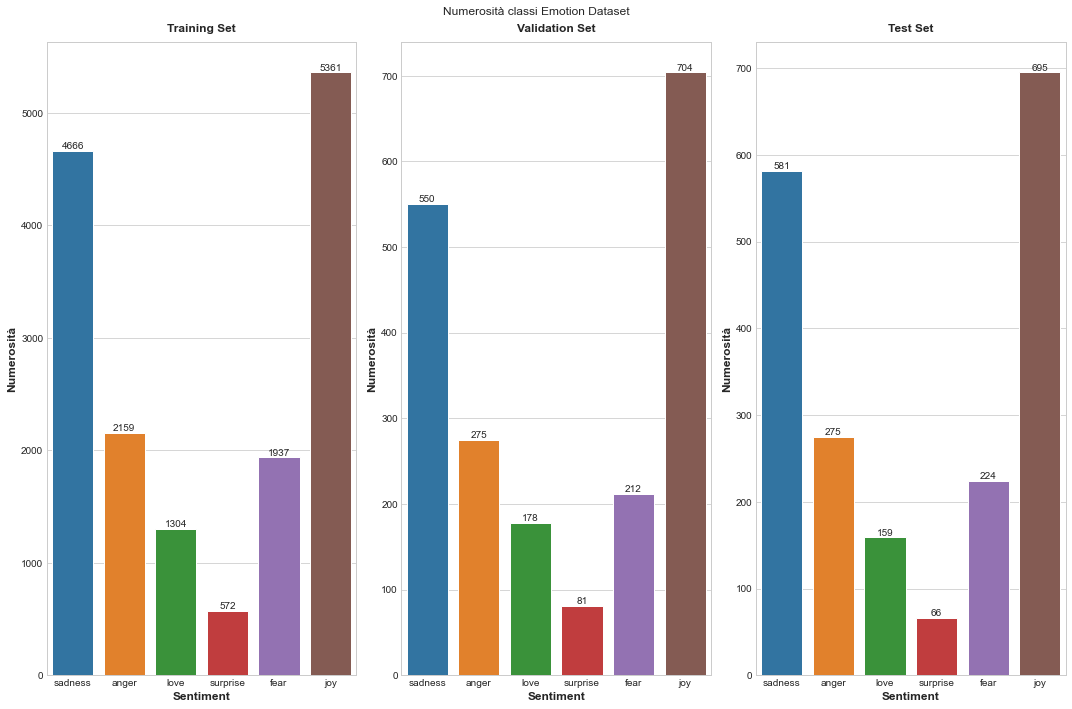

In [65]:
order = ['sadness', 'anger', 'love', 'surprise', 'fear', 'joy']

fig, ax = plt.subplots(1, 3, figsize=(15,10))
fig.suptitle('Numerosità classi Emotion Dataset')

sns.countplot(x='Sentiment', data=emotion_train, ax=ax[0], order=order)
ax[0].bar_label(ax[0].containers[0])
ax[0].set_title('Training Set')
ax[0].set_ylabel('Numerosità')
sns.countplot(x='Sentiment', data=emotion_val, ax=ax[1], order=order)
ax[1].bar_label(ax[1].containers[0])
ax[1].set_title('Validation Set')
ax[1].set_ylabel('Numerosità')
sns.countplot(x='Sentiment', data=emotion_test, ax=ax[2], order=order)
ax[2].bar_label(ax[2].containers[0])
ax[2].set_title('Test Set')
ax[2].set_ylabel('Numerosità')

plt.tight_layout()
plt.show()

Come detto in precedenza, la scelta di tale dataset è stata guidata proprio dalla presenza di molte etichette non naturalmente accorpabili. I record sono infatti etichettati in base all'emozione espressa semanticamente dalla frase, queste possono essere: _'sadness'_, _'anger'_, _'love'_, _'surprise'_, _'fear'_ e _'joy'_. Si può notare come sia presente dello sbilanciamento per quanto riguarda la numerosità delle label, che conserva lo stesso pattern a prescindere dalla tipologia di insieme preso in esame, con la classe _'joy'_ che risulta essere la più popolare, mentre _'surprise'_ si assesta all'utlimo posto.

Anche se apparentemente i dati sembrano abbastanza puliti, procediamo applicando le operazioni preliminari di _preprocessing_ e _cleaning_ definite ed impiegate anche in precedenza per le altre collezioni prese in esame:

In [66]:
emotion_train['CleanText'] = emotion_train['OriginalText'].apply(lambda x: rimuovi_spazi(clean(rimuovi_emoji(x))))
emotion_val['CleanText'] = emotion_val['OriginalText'].apply(lambda x: rimuovi_spazi(clean(rimuovi_emoji(x))))
emotion_test['CleanText'] = emotion_test['OriginalText'].apply(lambda x: rimuovi_spazi(clean(rimuovi_emoji(x))))

emotion_train['NoStopWords'] = emotion_train['CleanText'].apply(lambda x: rimuovi_stopwords(x))
emotion_val['NoStopWords'] = emotion_val['CleanText'].apply(lambda x: rimuovi_stopwords(x))
emotion_test['NoStopWords'] = emotion_test['CleanText'].apply(lambda x: rimuovi_stopwords(x))

print('Emotion DS:> Esempi puliti Training Set')
display(emotion_train[['OriginalText', 'CleanText', 'NoStopWords']].iloc[10:16])
print('Emotion DS:> Esempi puliti Validation Set')
display(emotion_val[['OriginalText', 'CleanText', 'NoStopWords']].iloc[10:16])
print('Emotion DS:> Esempi puliti Test Set')
display(emotion_test[['OriginalText', 'CleanText', 'NoStopWords']].iloc[10:16])

Emotion DS:> Esempi puliti Training Set


OriginalText  \
10  i feel like i have to make the suffering i m s...   
11  i do feel that running is a divine experience ...   
12  i think it s the easiest time of year to feel ...   
13                 i feel low energy i m just thirsty   
14  i have immense sympathy with the general point...   
15    i do not feel reassured anxiety is on each side   

                                            CleanText  \
10  i feel like i have to make the suffering i m s...   
11  i do feel that running is a divine experience ...   
12  i think it s the easiest time of year to feel ...   
13                 i feel low energy i m just thirsty   
14  i have immense sympathy with the general point...   
15    i do not feel reassured anxiety is on each side   

                                          NoStopWords  
10                  feel like suffering m seeing mean  
11  feel running divine experience expect type spi...  
12        think s easiest time year feel dissatisfied  
13                          feel low energy m thirsty  
14  immense sympathy general point possible proto ...  
15                             feel reassured anxiety

Emotion DS:> Esempi puliti Validation Set


OriginalText  \
10                 i feel bitchy but not defeated yet   
11  i was dribbling on mums coffee table looking o...   
12  i woke up often got up around am feeling pukey...   
13                          i was feeling sentimental   
14  i walked out of there an hour and fifteen minu...   
15  i never stop feeling thankful as to compare wi...   

                                            CleanText  \
10                 i feel bitchy but not defeated yet   
11  i was dribbling on mums coffee table looking o...   
12  i woke up often got up around am feeling pukey...   
13                          i was feeling sentimental   
14  i walked out of there an hour and fifteen minu...   
15  i never stop feeling thankful as to compare wi...   

                                          NoStopWords  
10                               feel bitchy defeated  
11  dribbling mums coffee table looking window fee...  
12            woke got feeling pukey radiation groggy  
13                                feeling sentimental  
14  walked hour minutes later feeling like beaten ...  
15  stop feeling thankful compare considered lucky...

Emotion DS:> Esempi puliti Test Set


OriginalText  \
10                 i don t feel particularly agitated   
11  i feel beautifully emotional knowing that thes...   
12  i pay attention it deepens into a feeling of b...   
13  i just feel extremely comfortable with the gro...   
14  i find myself in the odd position of feeling s...   
15  i was feeling as heartbroken as im sure katnis...   

                                            CleanText  \
10                 i don t feel particularly agitated   
11  i feel beautifully emotional knowing that thes...   
12  i pay attention it deepens into a feeling of b...   
13  i just feel extremely comfortable with the gro...   
14  i find myself in the odd position of feeling s...   
15  i was feeling as heartbroken as im sure katnis...   

                                          NoStopWords  
10                       t feel particularly agitated  
11  feel beautifully emotional knowing women knew ...  
12     pay attention deepens feeling invaded helpless  
13  feel extremely comfortable group people dont n...  
14                    odd position feeling supportive  
15                feeling heartbroken im sure katniss

Controllo nuovamente l'eventuale presenza di duplicati a fronte delle operazioni eseguite:

In [67]:
train_dupl = emotion_train.duplicated(subset=['CleanText', 'Sentiment']).sum()
val_dupl = emotion_val.duplicated(subset=['CleanText', 'Sentiment']).sum()
test_dupl = emotion_test.duplicated(subset=['CleanText', 'Sentiment']).sum()

print('Emotion DS:> Numero di duplicati presenti nel training set dopo le operazioni di pulizia del testo {};'.format(train_dupl))
print('Emotion DS:> Numero di duplicati presenti nel validation set dopo le operazioni di pulizia del testo {};'.format(val_dupl))
print('Emotion DS:> Numero di duplicati presenti nel test set dopo le operazioni di pulizia del testo {};\n'.format(test_dupl))

Emotion DS:> Numero di duplicati presenti nel training set dopo le operazioni di pulizia del testo 0;
Emotion DS:> Numero di duplicati presenti nel validation set dopo le operazioni di pulizia del testo 0;
Emotion DS:> Numero di duplicati presenti nel test set dopo le operazioni di pulizia del testo 0;



Procediamo l'analisi andando a mostrare alcune statistiche relative a tali insiemi di dati:

Statistice sulla lunghezza del Testo nei tre dataset:


mean        std  min  max  median   %25   %75  \
Emotion Training Set    19.16676  10.987102    2   66    17.0  11.0  25.0   
Emotion Validation Set  18.86600  10.813025    2   61    17.0  10.0  25.0   
Emotion Test Set        19.15400  11.012353    3   61    17.0  10.0  26.0   

                         %90  
Emotion Training Set    35.0  
Emotion Validation Set  34.0  
Emotion Test Set        35.0

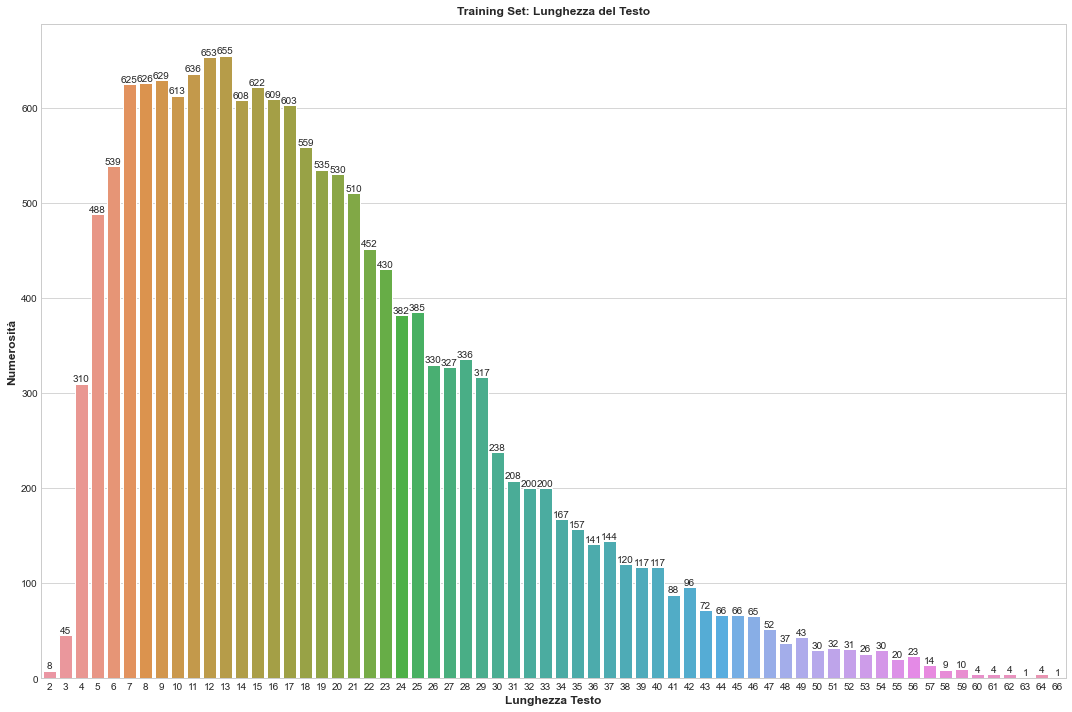

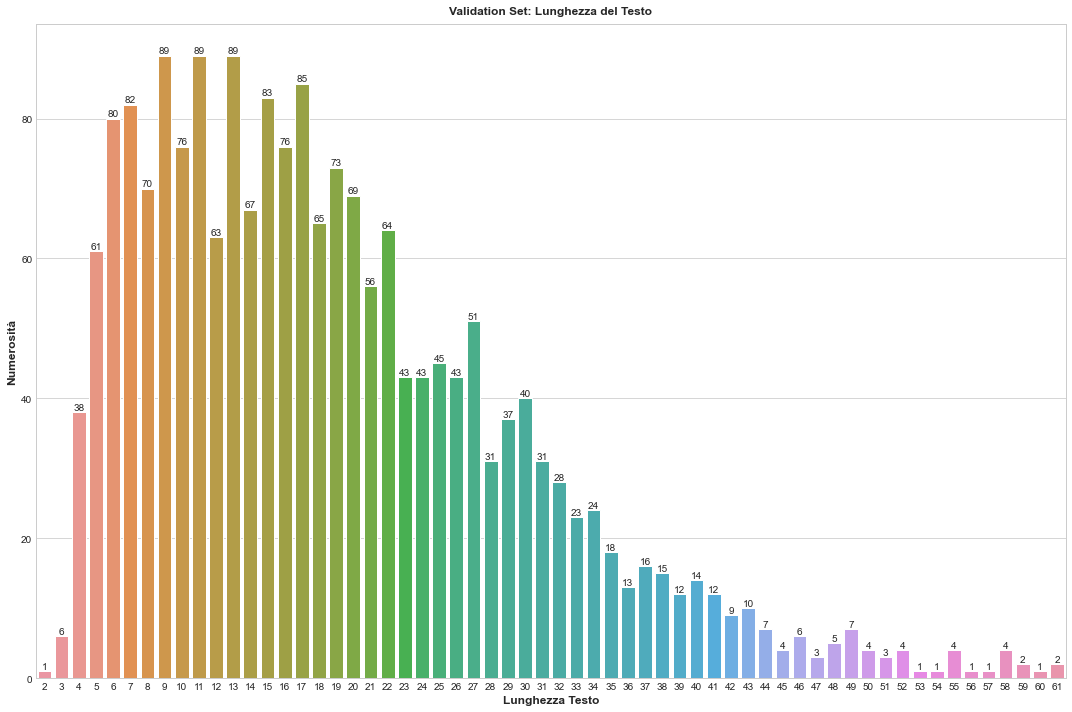

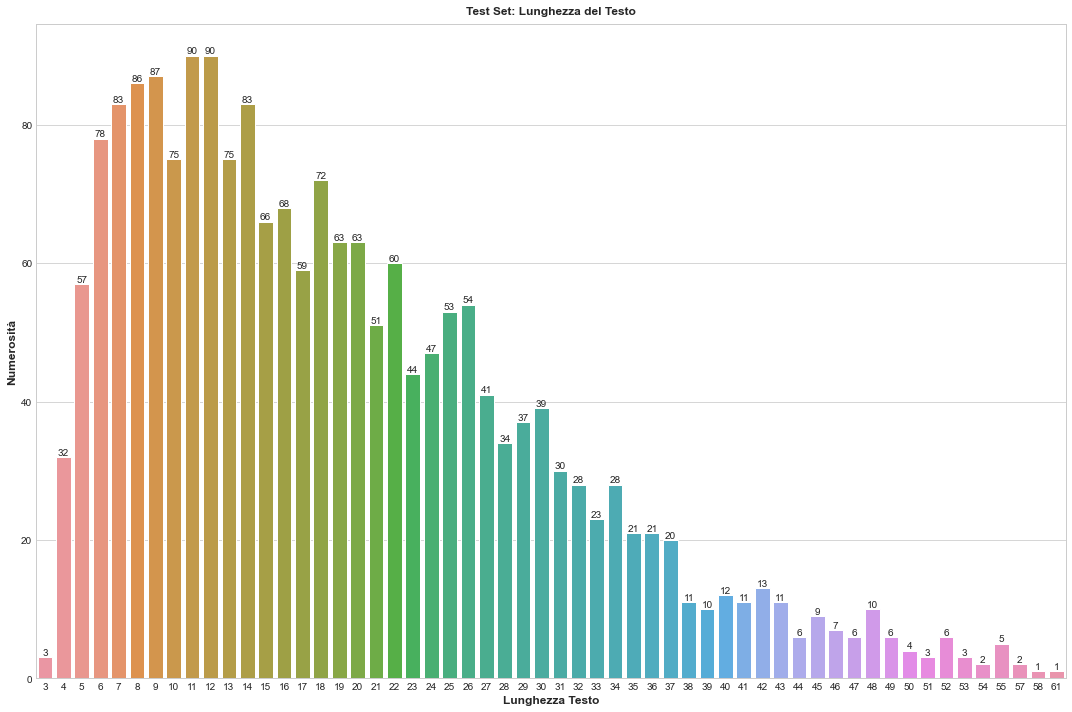

In [68]:
emotion_train['LenText'] = emotion_train['CleanText'].apply(lambda x: len(x.split()))
emotion_val['LenText'] = emotion_val['CleanText'].apply(lambda x: len(x.split()))
emotion_test['LenText'] = emotion_test['CleanText'].apply(lambda x: len(x.split()))

metriche = pd.DataFrame({'mean': [emotion_train['LenText'].mean(), emotion_val['LenText'].mean(), emotion_test['LenText'].mean()],
                         'std': [emotion_train['LenText'].std(), emotion_val['LenText'].std(), emotion_test['LenText'].std()],
                         'min': [emotion_train['LenText'].min(), emotion_val['LenText'].min(), emotion_test['LenText'].min()],
                         'max': [emotion_train['LenText'].max(), emotion_val['LenText'].max(), emotion_test['LenText'].max()],
                         'median': [emotion_train['LenText'].median(), emotion_val['LenText'].median(), emotion_test['LenText'].median()],
                         '%25': [emotion_train['LenText'].quantile(.25), emotion_val['LenText'].quantile(.25), emotion_test['LenText'].quantile(.25)],
                         '%75': [emotion_train['LenText'].quantile(.75), emotion_val['LenText'].quantile(.75), emotion_test['LenText'].quantile(.75)],
                         '%90': [emotion_train['LenText'].quantile(.9), emotion_val['LenText'].quantile(.9), emotion_test['LenText'].quantile(.9)]
                        }, index=['Emotion Training Set', 'Emotion Validation Set', 'Emotion Test Set'])

print('Statistice sulla lunghezza del Testo nei tre dataset:')
display(metriche)

fig = plt.figure(figsize=(15,10))
plt.title('Training Set: Lunghezza del Testo')
ax = sns.countplot(x='LenText', data=emotion_train)
ax.bar_label(ax.containers[0])
plt.xlabel('Lunghezza Testo')
plt.ylabel('Numerosità')
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(15,10))
plt.title('Validation Set: Lunghezza del Testo')
ax = sns.countplot(x='LenText', data=emotion_val)
ax.bar_label(ax.containers[0])
plt.xlabel('Lunghezza Testo')
plt.ylabel('Numerosità')
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(15,10))
plt.title('Test Set: Lunghezza del Testo')
ax = sns.countplot(x='LenText', data=emotion_test)
ax.bar_label(ax.containers[0])
plt.xlabel('Lunghezza Testo')
plt.ylabel('Numerosità')
plt.tight_layout()
plt.show()

La lunghezza dei testi risulta essere abbastanza compatibile (anche se inferiore) ai valori incontrati per il __Twitter Dataset__, siccome anche in questo caso ritroviamo esempi con un numero relativamente basso di token, si è deciso di procedere andando a rimuovere i record con lunghezza inferiore a 4 token. 

Emotion DS:> Numero di elementi nel trainig set dopo la rimozione 15946;
Emotion DS:> Numero di elementi nel validation set dopo la rimozione 1993;
Emotion DS:> Numero di elementi nel test set dopo la rimozione 1997;


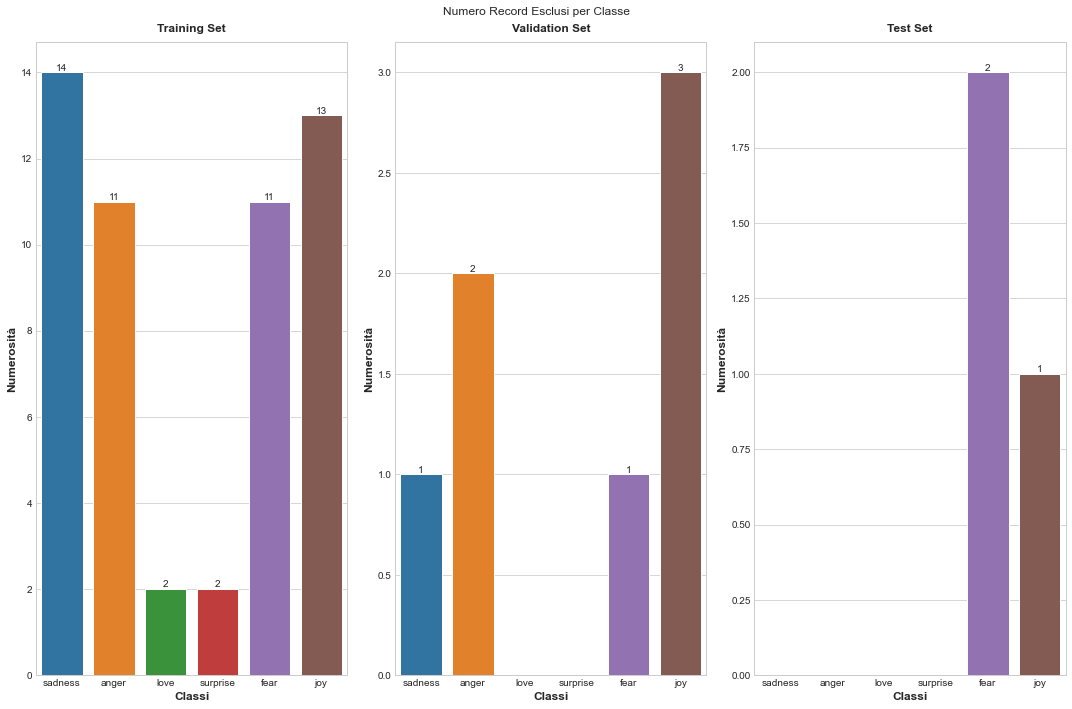

In [69]:
summary_train = emotion_train[emotion_train['LenText']<=3]
summary_val = emotion_val[emotion_val['LenText']<=3]
summary_test = emotion_test[emotion_test['LenText']<=3]


emotion_train = emotion_train[emotion_train['LenText']>3]
emotion_val = emotion_val[emotion_val['LenText']>3]
emotion_test = emotion_test[emotion_test['LenText']>3]

print('Emotion DS:> Numero di elementi nel trainig set dopo la rimozione {};'.format(emotion_train.shape[0]))
print('Emotion DS:> Numero di elementi nel validation set dopo la rimozione {};'.format(emotion_val.shape[0]))
print('Emotion DS:> Numero di elementi nel test set dopo la rimozione {};'.format(emotion_test.shape[0]))

order = ['sadness', 'anger', 'love', 'surprise', 'fear', 'joy']

fig, ax = plt.subplots(1, 3, figsize=(15,10))
fig.suptitle('Numero Record Esclusi per Classe')

sns.countplot(x='Sentiment', data=summary_train, ax=ax[0], order=order)
ax[0].bar_label(ax[0].containers[0])
ax[0].set_title('Training Set')
ax[0].set_ylabel('Numerosità')
ax[0].set_xlabel('Classi')
sns.countplot(x='Sentiment', data=summary_val, ax=ax[1], order=order)
ax[1].bar_label(ax[1].containers[0])
ax[1].set_title('Validation Set')
ax[1].set_ylabel('Numerosità')
ax[1].set_xlabel('Classi')
sns.countplot(x='Sentiment', data=summary_test, ax=ax[2], order=order)
ax[2].bar_label(ax[2].containers[0])
ax[2].set_title('Test Set')
ax[2].set_ylabel('Numerosità')
ax[2].set_xlabel('Classi')

plt.tight_layout()
plt.show()

In questo caso era abbastanza difficile andare ad ipotizzare un risultato atteso, questo perchè la semantica e l'emozione espressa dalla frase molto spesso prescinde dalla lunghezza della stessa. Anche con un numero basso di termini, in base alle parole impiegate, si possono esprimere quasi tutti i _sentiment_ su cui stiamo lavorando nel seguente dataset. 

In [70]:
print('Esempi di frasi eliminate:')
summary_train['OriginalText'].head(5)

Esempi di frasi eliminate:


237    im feeling cranky
303        fear of thief
731      im feeling fine
888      i feel bothered
951       id feel better
Name: OriginalText, dtype: object

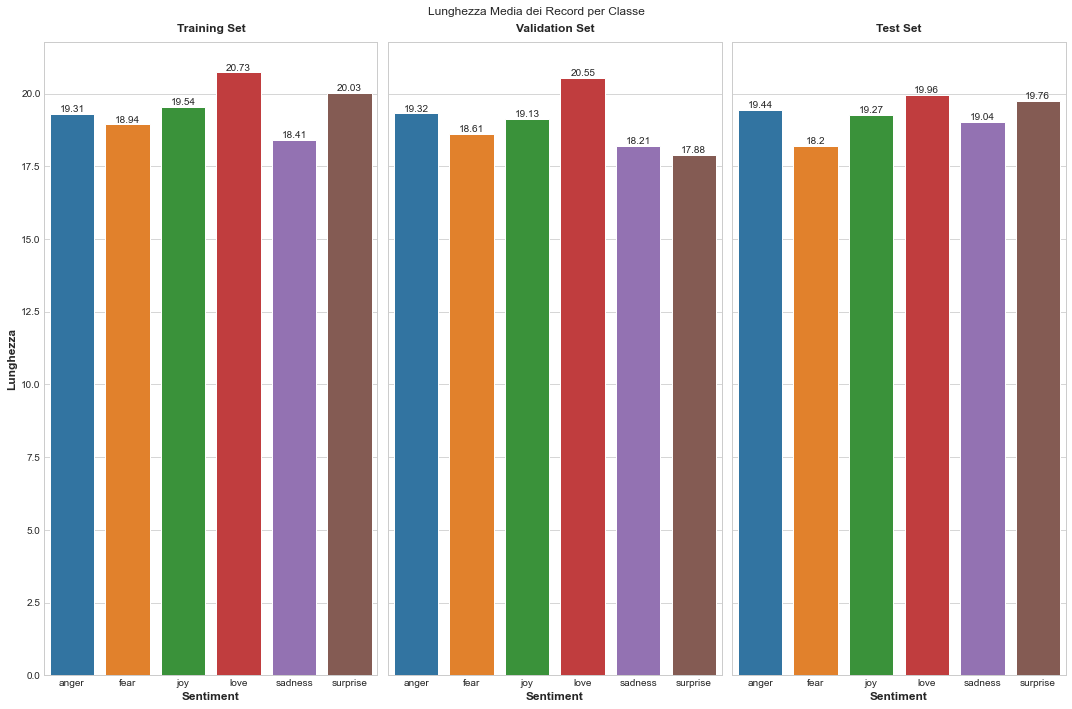

In [71]:
gb_train = emotion_train.groupby('Sentiment')['LenText'].mean().round(2)
gb_val = emotion_val.groupby('Sentiment')['LenText'].mean().round(2)
gb_test = emotion_test.groupby('Sentiment')['LenText'].mean().round(2)

fig, ax = plt.subplots(1, 3, figsize=(15,10), sharey=True)
fig.suptitle('Lunghezza Media dei Record per Classe')

sns.barplot(x=gb_train.index, y=gb_train.values, ax=ax[0])
ax[0].set_title('Training Set')
ax[0].bar_label(ax[0].containers[0])
ax[0].set_ylabel('Lunghezza')
sns.barplot(x=gb_val.index, y=gb_val.values, ax=ax[1])
ax[1].set_title('Validation Set')
ax[1].bar_label(ax[1].containers[0])
sns.barplot(x=gb_test.index, y=gb_test.values, ax=ax[2])
ax[2].set_title('Test Set')
ax[2].bar_label(ax[2].containers[0])

plt.tight_layout()
plt.show()

Procediamo l'analisi andando a generare le _wordcloud_ con le parore più frequenti nel testo selezionate in base alla classe di apparteneza dei record, insieme ai bigrammi e trigrammi più frequenti:

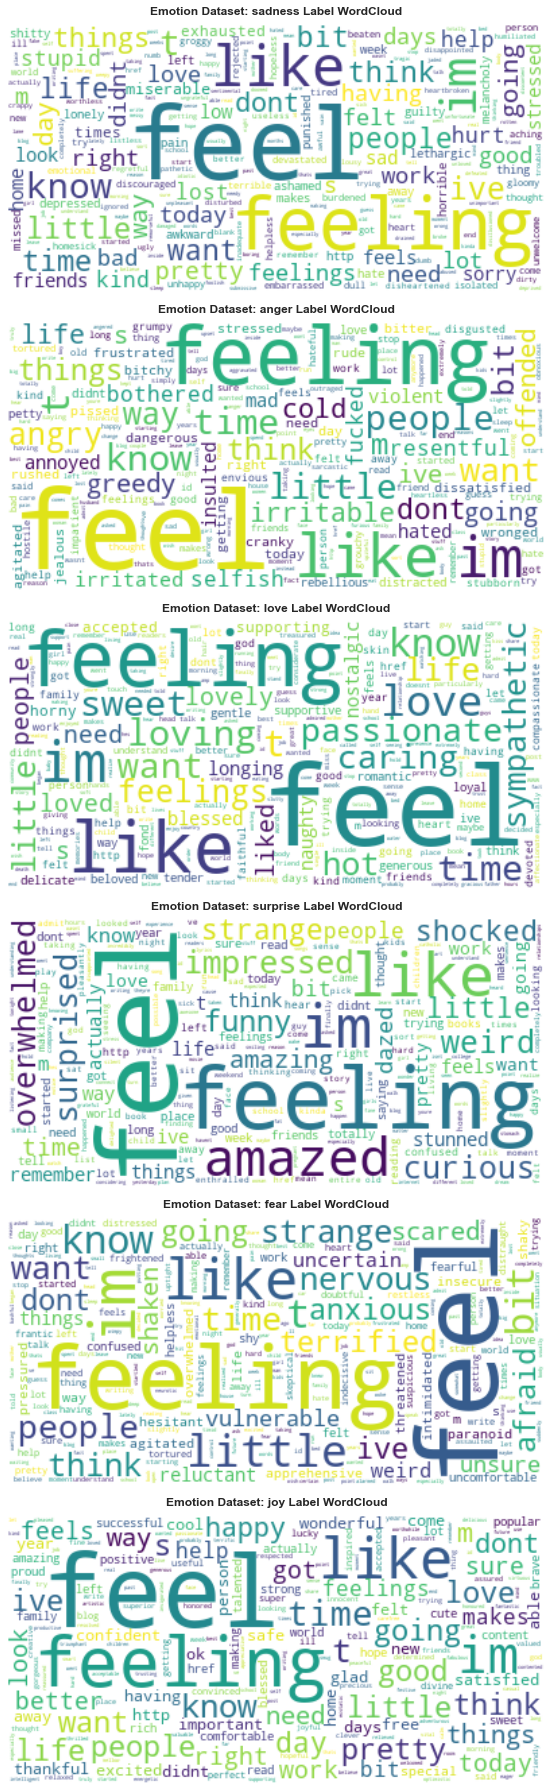

In [72]:
generate_cloud(emotion_train, 'Emotion Dataset', words=300)

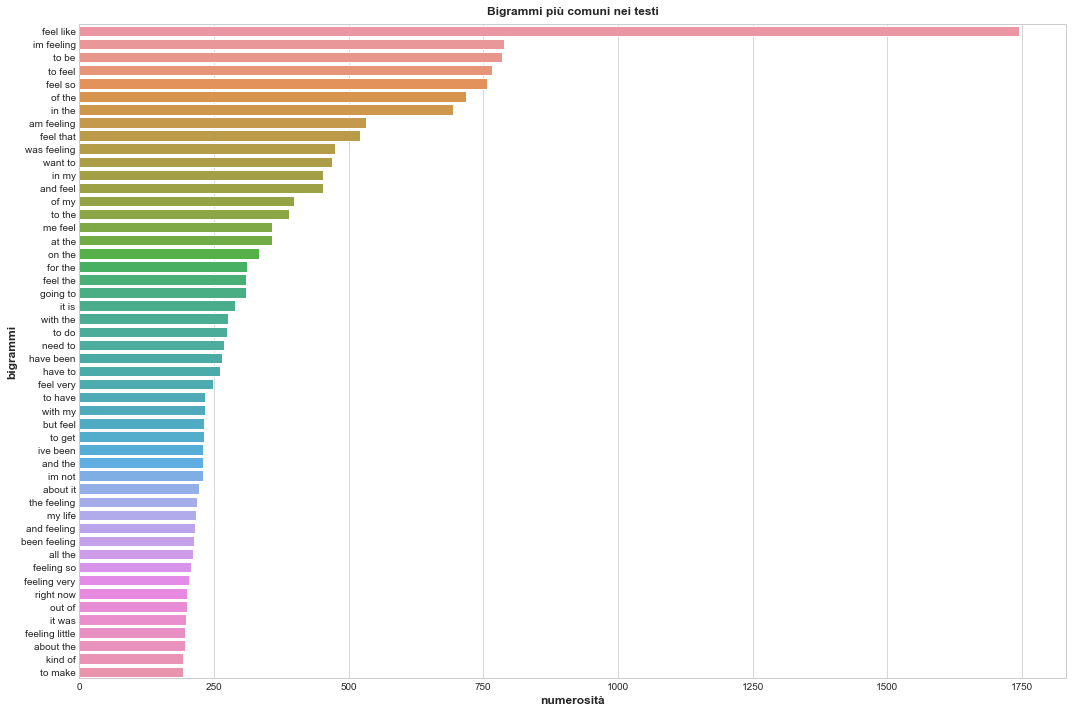

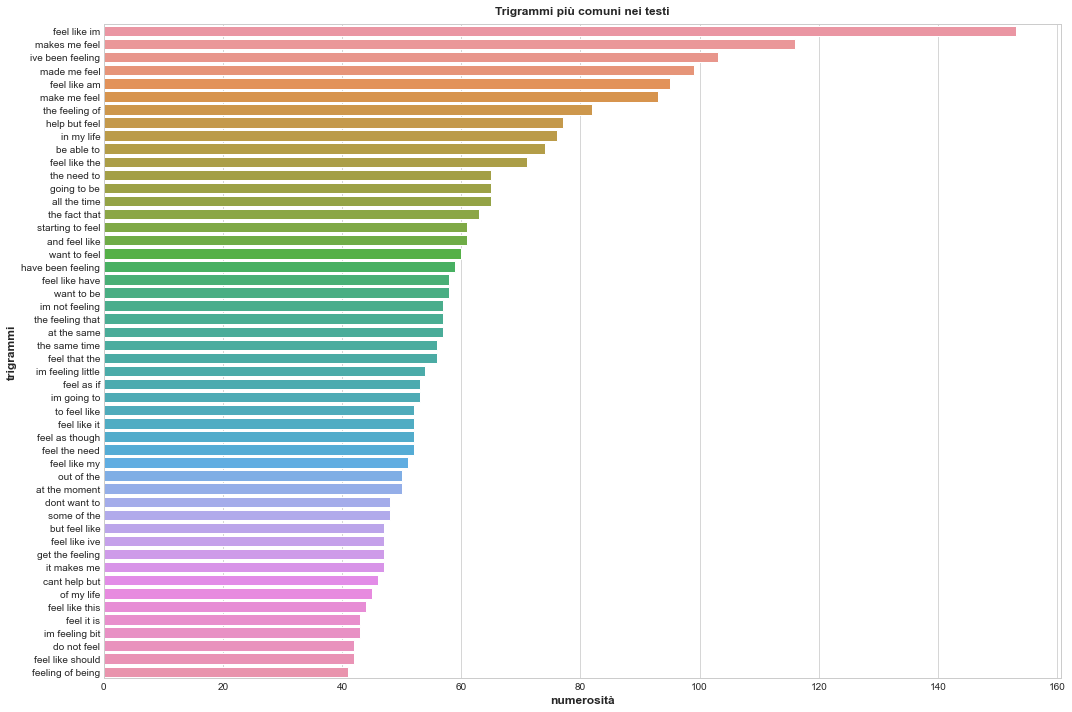

In [73]:
bigram = get_top_ngrams(emotion_train['CleanText'], 50, 2)
trigram = get_top_ngrams(emotion_train['CleanText'], 50, 3)

plt.figure(figsize=(15,10))
p = sns.barplot(y = bigram.index, x = bigram['count'].values)
plt.title("Bigrammi più comuni nei testi")
plt.xlabel("numerosità")
plt.ylabel("bigrammi")
plt.tight_layout()
plt.show()

plt.figure(figsize=(15,10))
p = sns.barplot(y = trigram.index, x = trigram['count'].values)
plt.title("Trigrammi più comuni nei testi")
plt.xlabel("numerosità")
plt.ylabel("trigrammi")
plt.tight_layout()
plt.show()

Anche in questo caso è palese il contesto in cui si sta lavorando, non ci si deve quindi stupire se le parole maggiormente frequenti nella collezione sono _'feel'_, _'feeling'_ e _'like'_, perchè appunto si sta lavorando con testi che fanno riferimento ad emozioni espresse.

Concludiamo la prima fase di esplorazione dei dataset andando a terminare le operazioni di preprocessing sull' __Emotion Dataset__ applicando il  __BertTokenizerFast__ per ottenere i verrori di __input_id__ e __attention_mask__ per ognuno dei tre insiemi. Siccome sono state evidenziate le similitudini con il __Twitter Dataset__ rispetto alla lunghezza dei testi, si seleziona la medesima soglia pari a 128 come lunghezza massima dei vettori output del tokenizzatore, che costituiranno poi l'input del nostro modello di rete.

In [74]:
token_len_train = emotion_train['CleanText'].apply(lambda x : len(bert_tokenizer.encode(x))).max()
token_len_val = emotion_val['CleanText'].apply(lambda x : len(bert_tokenizer.encode(x))).max()
token_len_test = emotion_test['CleanText'].apply(lambda x : len(bert_tokenizer.encode(x))).max()

print('Emotion DS:> Numero massimo di token ottenuti nel Training Set {}'.format(token_len_train))
print('Emotion DS:> Numero massimo di token ottenuti nel Validation Set {}'.format(token_len_val))
print('Emotion DS:> Numero massimo di token ottenuti nel Test Set {}'.format(token_len_test))

Emotion DS:> Numero massimo di token ottenuti nel Training Set 87
Emotion DS:> Numero massimo di token ottenuti nel Validation Set 69
Emotion DS:> Numero massimo di token ottenuti nel Test Set 66


In [75]:
MAX_LEN = 128

In [76]:
# impiego il bert_tokenizer definito precedentemente

x_train_em_ids, x_train_em_masks = get_token(emotion_train['CleanText'].values, bert_tokenizer, MAX_LEN)
x_valid_em_ids, x_valid_em_masks = get_token(emotion_val['CleanText'].values, bert_tokenizer, MAX_LEN)
x_test_em_ids, x_test_em_masks = get_token(emotion_test['CleanText'].values, bert_tokenizer, MAX_LEN)

In [77]:
print('Emotion DS:> Dimensione Training Set [Ids/Masks] {}/{}'.format(x_train_em_ids.shape, x_train_em_masks.shape))
print('Emotion DS:> Dimensione Validation Set [Ids/Masks] {}/{}'.format(x_valid_em_ids.shape, x_valid_em_masks.shape))
print('Emotion DS:> Dimensione Test Set [Ids/Masks] {}/{}'.format(x_test_em_ids.shape, x_test_em_masks.shape))

Emotion DS:> Dimensione Training Set [Ids/Masks] (15946, 128)/(15946, 128)
Emotion DS:> Dimensione Validation Set [Ids/Masks] (1993, 128)/(1993, 128)
Emotion DS:> Dimensione Test Set [Ids/Masks] (1997, 128)/(1997, 128)


In [78]:
print('Emotion DS:> Esempio Vettore di Id e Mask')
x_train_em_ids[0], x_train_em_masks[0]

Emotion DS:> Esempio Vettore di Id e Mask


(array([  101,  1045,  2134,  2102,  2514, 26608,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
      

Applico _OneHotEncoding_ alle etichette di classe: 

In [79]:
o = OneHotEncoder()

y_train_em = o.fit_transform(emotion_train['Sentiment'].values.reshape(-1, 1)).toarray()
y_valid_em = o.fit_transform(emotion_val['Sentiment'].values.reshape(-1, 1)).toarray()
y_test_em = o.fit_transform(emotion_test['Sentiment'].values.reshape(-1, 1)).toarray()

In [80]:
print('Emotion DS:> Esempio etichette di classe post encoding')
y_train_em

Emotion DS:> Esempio etichette di classe post encoding


array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.]])

In [81]:
exists = os.path.isfile(os.path.join(PREPROC_DIR, 'emotion_train.csv'))
if not exists:
    emotion_train[['CleanText', 'Sentiment']].to_csv(os.path.join(PREPROC_DIR, 'emotion_train.csv'), index=False)
        
exists = os.path.isfile(os.path.join(PREPROC_DIR, 'emotion_test.csv'))
if not exists:
    emotion_test[['CleanText', 'Sentiment']].to_csv(os.path.join(PREPROC_DIR, 'emotion_test.csv'), index=False)

# Modellazione

Definisco alcune funzioni di utilità che mi serviranno successivamente:

In [82]:
def hist_plot(history_dict, title): # metodo che permette il plot dei grafici di accuracy e loss per train e validation set
    acc = history_dict['categorical_accuracy']
    val_acc = history_dict['val_categorical_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    e = range(1, len(acc) + 1)

    fig = plt.figure(figsize=(10, 7))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(e, acc, 'b', label='Training acc')
    ax1.plot(e, val_acc, 'r-', label='Validation acc')
    ax1.set_title('Accuracy Over Epochs')
    ax1.set_xlabel('Epochs')
    ax1.set_xticks(e)
    ax1.set_ylabel('Accuracy')
    ax1.legend(loc='lower right')

    ax2 = fig.add_subplot(1, 2, 2)
    ax2.plot(e, loss, 'c', label='Training loss')
    ax2.plot(e, val_loss, 'g-', label='Validation loss')
    ax2.set_title('Loss Over Epochs')
    ax2.set_xlabel('Epochs')
    ax2.set_xticks(e)
    ax2.set_ylabel('Loss')
    ax2.legend(loc='lower left')

    fig.suptitle(title)
    fig.tight_layout()
    plt.show()

L'idea alla base di tale analisi progettuale è quella di implementare un modello di rete generico che si andrà ad impiegare, a meno di alcune differenze rispetto alla taglia dell'input e dell'output, sui vari dataset dipsonibili. Questo con lo scopo di andare meglio ad analizzare le caratteristiche e performance intrinseche di __BERT__ sui vari contesti, a prescindere dall'impiego di architetture ad-hoc. \
Si sottolinea inoltre il fatto che si sta impiegando un'architettura di _embedding_ pre-addestrata per task di _masked language modeling_ su testi in inglese, sostanzialmente stiamo quindi applicando il paradigma del __transfer learnings__. \
Importante è il fatto che si andranno sostanzialmente ad impiegare e testare due modelli differenti per dataset, un primo modello in cui si andrà ad addestrare unicamente la porzione della rete posta in 'testa' al _transformer_ per ottenere il risultato della classificazione. \
Nel secondo modello inviece si andrà ad attuare _fine-tuning_ dell'intera architettura, ossia si renderà addestrabile anche la porzione _transformer_, cercando quindi di tarare meglio i pesi di __BERT__ sullo specifico dataset impiegato e task da risolvere. Questo ovviamente comporterà un notevo aumento dei tempi di addestramento.

In [83]:
def create_model(max_len, output_len, trainable=False):
    
    opt = tf.keras.optimizers.Adam(learning_rate=1e-5, decay=1e-7)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()
    
    bert = TFBertModel.from_pretrained('bert-base-uncased')
    bert.trainable = trainable


    input_ids = tf.keras.Input(shape=(max_len,), dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,), dtype='int32')
    
    embeddings = bert([input_ids,attention_masks])[1]
    hidden = tf.keras.layers.Dense(16, activation="relu")(embeddings)
    drop = tf.keras.layers.Dropout(.25)(hidden)
    output = tf.keras.layers.Dense(output_len, activation="softmax")(drop)
    
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks], outputs = output)
    model.compile(opt, loss=loss, metrics=accuracy)
    
    return model

Definisco ora alcune costanti per la fase di training. Anche in questo caso si cerca di rendere l'approccio all'apprendimento il meno personalizzato possibile, al fine di sottolineare e analizzare meglio le performance sul contesto specifico a prescindere dalle modalità con cui si vanno ad addestrare i modelli sui vari dataset.

In [84]:
EPOCHS = 5

MAX_LEN_TW = 128
MAX_LEN_IMDB = 250
MAX_LEN_EMOTION = 128

OUTPUT_LEN_TW = 3
OUTPUT_LEN_IMDB = 2
OUTPUT_LEN_EMOTION = 6

## Twitter Dataset Training

In [85]:
model_tw_base = create_model(MAX_LEN_TW, OUTPUT_LEN_TW, trainable=False)
model_tw_fine = create_model(MAX_LEN_TW, OUTPUT_LEN_TW, trainable=True)

In [86]:
print("Architettura di rete generale impiegata:\n")
model_tw_base.summary()

Architettura di rete generale impiegata:

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 128, 

In [87]:
print("Twitter DS:> Parametri addestrabili nel modello di base {}".format(count_params(model_tw_base.trainable_weights)))
print("Twitter DS:> Parametri addestrabili nel modello fine-tuned {}".format(count_params(model_tw_fine.trainable_weights)))

Twitter DS:> Parametri addestrabili nel modello di base 12355
Twitter DS:> Parametri addestrabili nel modello fine-tuned 109494595


In [88]:
exists = os.path.isfile(os.path.join(DUMP_DIR, 'model_tw_base.hist'))
if exists:
    print('Twitter DS:> Caricamento pesi del modello di base...')
    with open(os.path.join(DUMP_DIR, 'model_tw_base.hist'), 'rb') as hist_file:
        hd_tw_base = pickle.load(hist_file)
    model_tw_base.load_weights(os.path.join(DUMP_DIR, 'model_tw_base_w'))
    print('Twitter DS:> Caricamento avvenuto con successo!')
else:
    history = model_tw_base.fit([x_train_tw_ids,x_train_tw_masks], 
                                y_train_tw,
                                validation_data=([x_valid_tw_ids,x_valid_tw_masks], y_valid_tw), 
                                epochs=EPOCHS, 
                                batch_size=16
                               )
    hd = history.history
    with open(os.path.join(DUMP_DIR, 'model_tw_base.hist'), 'wb') as hist_file:
        pickle.dump(hd, hist_file)
    model_tw_base.save_weights(os.path.join(DUMP_DIR, 'model_tw_base_w'))

Twitter DS:> Caricamento pesi del modello di base...
Twitter DS:> Caricamento avvenuto con successo!


In [89]:
exists = os.path.isfile(os.path.join(DUMP_DIR, 'model_tw_fine.hist'))
if exists:
    print('Twitter DS:> Caricamento pesi del modello fine-tuned...')
    with open(os.path.join(DUMP_DIR, 'model_tw_fine.hist'), 'rb') as hist_file:
        hd_tw_fine = pickle.load(hist_file)
    model_tw_fine.load_weights(os.path.join(DUMP_DIR, 'model_tw_fine_w'))
    print('Twitter DS:> Caricamento avvenuto con successo!')
else:
    history = model_tw_fine.fit([x_train_tw_ids,x_train_tw_masks], 
                                y_train_tw,
                                validation_data=([x_valid_tw_ids,x_valid_tw_masks], y_valid_tw), 
                                epochs=EPOCHS, 
                                batch_size=16
                               )
    hd = history.history
    with open(os.path.join(DUMP_DIR, 'model_tw_fine.hist'), 'wb') as hist_file:
        pickle.dump(hd, hist_file)
    model_tw_fine.save_weights(os.path.join(DUMP_DIR, 'model_tw_fine_w'))

Twitter DS:> Caricamento pesi del modello fine-tuned...
Twitter DS:> Caricamento avvenuto con successo!


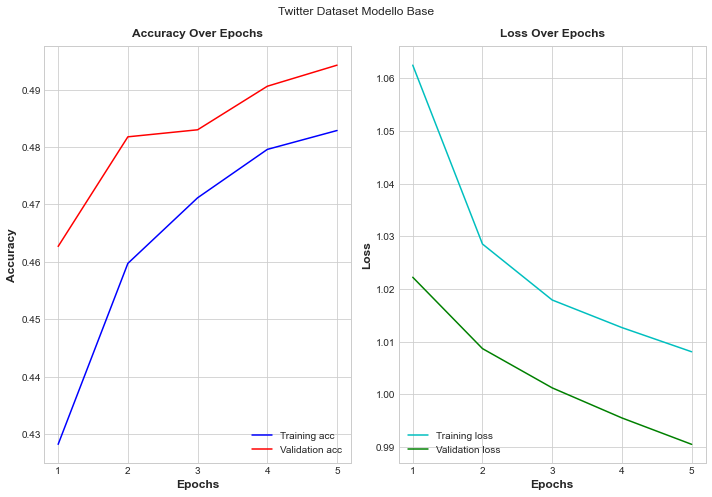

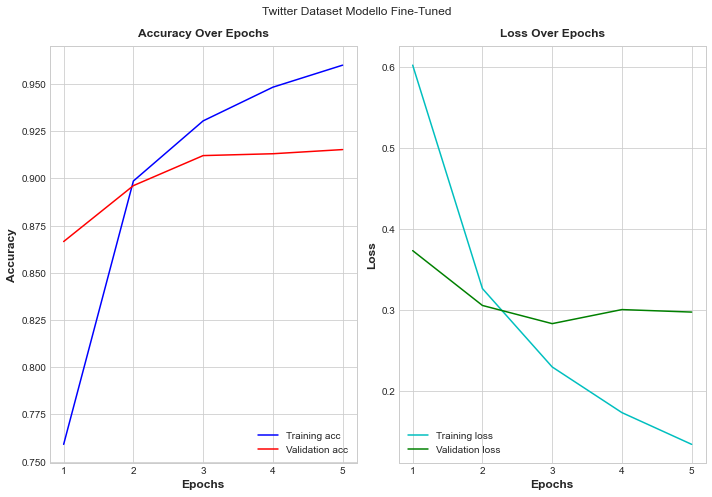

In [90]:
hist_plot(hd_tw_base, title='Twitter Dataset Modello Base')
hist_plot(hd_tw_fine, title='Twitter Dataset Modello Fine-Tuned')

Si può facilmente osservare come il modello base probabilmente necessitava di ulteriori epoche di addestramento, questo infatti non riesce a raggiungere risultati soddidsfacenti, molto probabilmente per via dell'elevata semplicità della porzione di rete adibita alla classificazione. \
Al contrario effettuare _fine-tuning_ porta il modello ad ottenere degli ottimi risultati, estremamente superiori rispetto alla controparte di base. Addirittura si può osservare dalla curva della _loss_ come molto probabilmente si stava accennando un principio di _overfitting_, perciò si può assumere che anche usando un numero inferiore di epoche si sarebbero raggiunti gli stessi risultati.

## IMDB Dataset Training

In [91]:
model_imdb_base = create_model(MAX_LEN_IMDB, OUTPUT_LEN_IMDB, trainable=False)
model_imdb_fine = create_model(MAX_LEN_IMDB, OUTPUT_LEN_IMDB, trainable=True)

In [92]:
print("Architettura di rete generale impiegata:\n")
model_imdb_base.summary()

Architettura di rete generale impiegata:

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 250)]        0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 250)]        0           []                               
                                                                                                  
 tf_bert_model_2 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_5[0][0]',                
                                thPoolingAndCrossAt               'input_6[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 250

In [93]:
print("IMDB DS:> Parametri addestrabili nel modello di base {}".format(count_params(model_imdb_base.trainable_weights)))
print("IMDB DS:> Parametri addestrabili nel modello di fine-tuned {}".format(count_params(model_imdb_fine.trainable_weights)))

IMDB DS:> Parametri addestrabili nel modello di base 12338
IMDB DS:> Parametri addestrabili nel modello di fine-tuned 109494578


In [94]:
exists = os.path.isfile(os.path.join(DUMP_DIR, 'model_imdb_base.hist'))
if exists:
    print('IMDB DS:> Caricamento pesi del modello di base...')
    with open(os.path.join(DUMP_DIR, 'model_imdb_base.hist'), 'rb') as hist_file:
        hd_imdb_base = pickle.load(hist_file)
    model_imdb_base.load_weights(os.path.join(DUMP_DIR, 'model_imdb_base_w'))
    print('IMDB DS:> Caricamento avvenuto con successo!')
else:
    history = model_imdb_base.fit([x_train_imdb_ids,x_train_imdb_masks], 
                                  y_train_imdb,
                                  validation_data=([x_valid_imdb_ids,x_valid_imdb_masks], y_valid_imdb), 
                                  epochs=EPOCHS, 
                                  batch_size=8
                                 )
    hd = history.history
    with open(os.path.join(DUMP_DIR, 'model_imdb_base.hist'), 'wb') as hist_file:
        pickle.dump(hd, hist_file)
    model_imdb_base.save_weights(os.path.join(DUMP_DIR, 'model_imdb_base_w'))

IMDB DS:> Caricamento pesi del modello di base...
IMDB DS:> Caricamento avvenuto con successo!


In [95]:
exists = os.path.isfile(os.path.join(DUMP_DIR, 'model_imdb_fine.hist'))
if exists:
    print('IMDB DS:> Caricamento pesi del modello fine-tuned...')
    with open(os.path.join(DUMP_DIR, 'model_imdb_fine.hist'), 'rb') as hist_file:
        hd_imdb_fine = pickle.load(hist_file)
    model_imdb_fine.load_weights(os.path.join(DUMP_DIR, 'model_imdb_fine_w'))
    print('IMDB DS:> Caricamento avvenuto con successo!')
else:
    history = model_imdb_fine.fit([x_train_imdb_ids,x_train_imdb_masks], 
                                  y_train_imdb,
                                  validation_data=([x_valid_imdb_ids,x_valid_imdb_masks], y_valid_imdb), 
                                  epochs=EPOCHS, 
                                  batch_size=6
                                 )
    hd = history.history
    with open(os.path.join(DUMP_DIR, 'model_imdb_fine.hist'), 'wb') as hist_file:
        pickle.dump(hd, hist_file)
    model_imdb_fine.save_weights(os.path.join(DUMP_DIR, 'model_imdb_fine_w'))

IMDB DS:> Caricamento pesi del modello fine-tuned...
IMDB DS:> Caricamento avvenuto con successo!


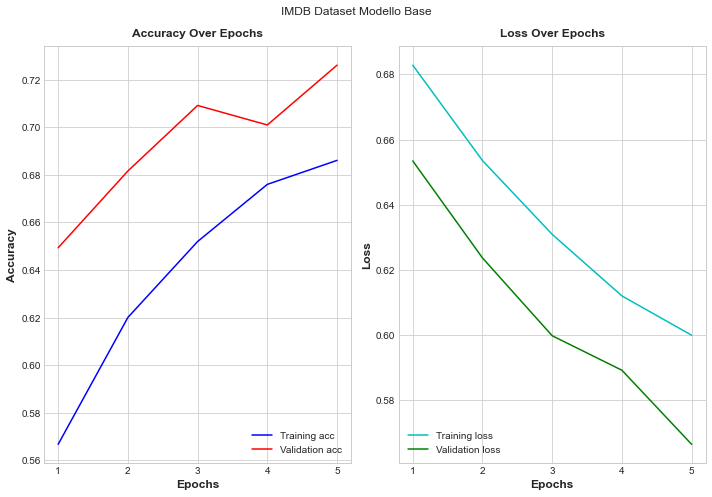

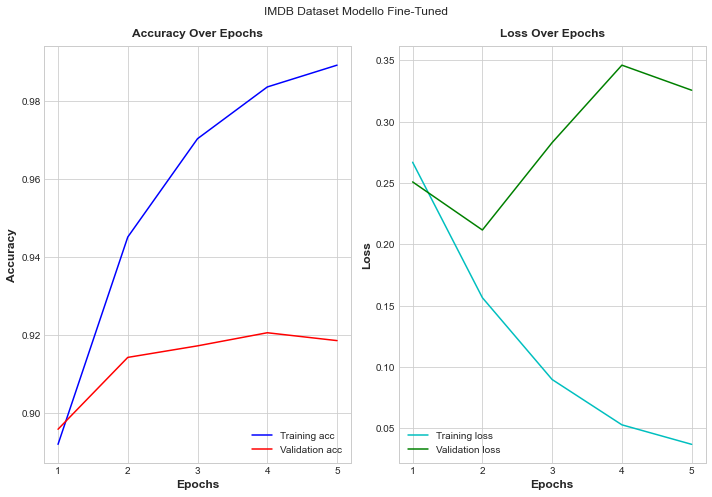

In [96]:
hist_plot(hd_imdb_base, title='IMDB Dataset Modello Base')
hist_plot(hd_imdb_fine, title='IMDB Dataset Modello Fine-Tuned')

In questo caso si può notare invece un comportamento nettamente migliore del modello base su tale dataset rispetto all'insieme di tweet, come nel caso precedente però sarebbero servite un numero superiore di epoche per poter raggiungere risultati migliori. Il modello _fine-tuned_ invece riesce facilmente ad ottenere ottimi valori sul _validation set_ anche se nelle ultime iterazioni le prestazioni in termini di _loss_ vanno a peggiorare.

## Emotion Dataset Training

In [97]:
model_emotion_base = create_model(MAX_LEN_EMOTION, OUTPUT_LEN_EMOTION, trainable=False)
model_emotion_fine = create_model(MAX_LEN_EMOTION, OUTPUT_LEN_EMOTION, trainable=True)

In [98]:
print("Architettura di rete generale impiegata:\n")
model_emotion_base.summary()

Architettura di rete generale impiegata:

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model_4 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_9[0][0]',                
                                thPoolingAndCrossAt               'input_10[0][0]']               
                                tentions(last_hidde                                               
                                n_state=(None, 128

In [99]:
print("Emotion DS:> Parametri addestrabili nel modello di base {}".format(count_params(model_emotion_base.trainable_weights)))
print("Emotion DS:> Parametri addestrabili nel modello di fine-tuned {}".format(count_params(model_emotion_fine.trainable_weights)))

Emotion DS:> Parametri addestrabili nel modello di base 12406
Emotion DS:> Parametri addestrabili nel modello di fine-tuned 109494646


In [100]:
exists = os.path.isfile(os.path.join(DUMP_DIR, 'model_emotion_base.hist'))
if exists:
    print('Emotion DS:> Caricamento pesi del modello di base...')
    with open(os.path.join(DUMP_DIR, 'model_emotion_base.hist'), 'rb') as hist_file:
        hd_emotion_base = pickle.load(hist_file)
    model_emotion_base.load_weights(os.path.join(DUMP_DIR, 'model_emotion_base_w'))
    print('Emotion DS:> Caricamento avvenuto con successo!')
else:
    history = model_emotion_base.fit([x_train_em_ids,x_train_em_masks], 
                                     y_train_em,
                                     validation_data=([x_valid_em_ids,x_valid_em_masks], y_valid_em), 
                                     epochs=EPOCHS, 
                                     batch_size=16
                                    )
    hd = history.history
    with open(os.path.join(DUMP_DIR, 'model_emotion_base.hist'), 'wb') as hist_file:
        pickle.dump(hd, hist_file)
    model_emotion_base.save_weights(os.path.join(DUMP_DIR, 'model_emotion_base_w'))

Emotion DS:> Caricamento pesi del modello di base...
Emotion DS:> Caricamento avvenuto con successo!


In [101]:
exists = os.path.isfile(os.path.join(DUMP_DIR, 'model_emotion_fine.hist'))
if exists:
    print('Emotion DS:> Caricamento pesi del modello fine-tuned...')
    with open(os.path.join(DUMP_DIR, 'model_emotion_fine.hist'), 'rb') as hist_file:
        hd_emotion_fine = pickle.load(hist_file)
    model_emotion_fine.load_weights(os.path.join(DUMP_DIR, 'model_emotion_fine_w'))
    print('Emotion DS:> Caricamento avvenuto con successo!')
else:
    history = model_emotion_fine.fit([x_train_em_ids,x_train_em_masks], 
                                     y_train_em,
                                     validation_data=([x_valid_em_ids,x_valid_em_masks], y_valid_em), 
                                     epochs=EPOCHS, 
                                     batch_size=3
                                    )
    hd = history.history
    with open(os.path.join(DUMP_DIR, 'model_emotion_fine.hist'), 'wb') as hist_file:
        pickle.dump(hd, hist_file)
    model_emotion_fine.save_weights(os.path.join(DUMP_DIR, 'model_emotion_fine_w'))

Emotion DS:> Caricamento pesi del modello fine-tuned...
Emotion DS:> Caricamento avvenuto con successo!


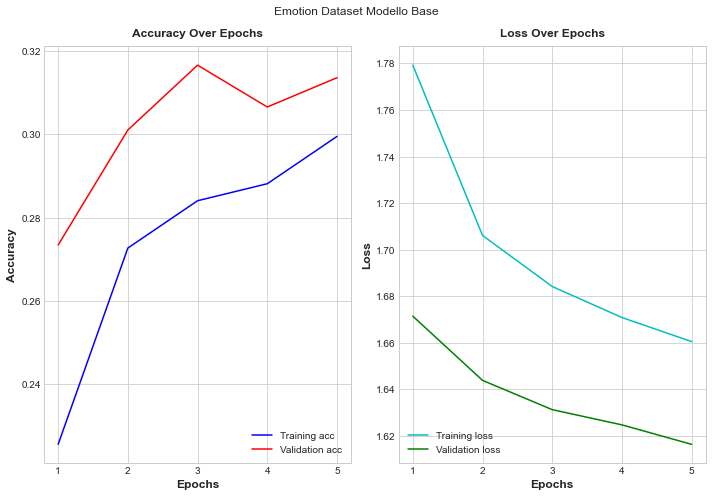

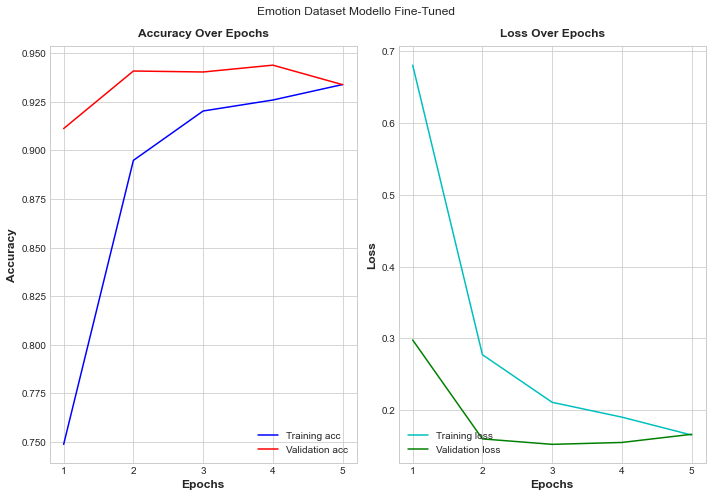

In [102]:
hist_plot(hd_emotion_base, title='Emotion Dataset Modello Base')
hist_plot(hd_emotion_fine, title='Emotion Dataset Modello Fine-Tuned')

Sull' __Emotion Dataset__ l'applicazione del modello base restituisce i risultati in fase di training peggiori tra tutte le collezioni di testi analizzate, molto probabilmente dovuto all'inferiore numero di record ed all'elevato numero di etichette di classe rispetto agli altri _dataset_. Al contrario l'apprendimento _fine-tuned_ del secondo modello restituisce i risultati migliori in termini di accuratezza sul _validation set_, inoltre apparentemente sembra che il numero pari a 5 di epoche sia stato in questo caso la scelta più adatta, andando ad ottenere sostanzialmente il punto in cui le curve di _loss_ e _accuracy_ su _train_ e _validation set_ si toccano.

# Valutazione

Definisco dei metodi di utilità:

In [167]:
def conf_matrix(y, y_pred, title, labels): # metodo che permette il calcolo e plot della matrice di confusione
    fig, ax =plt.subplots(figsize=(6,6))
    labels=labels
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Blues", fmt='g', cbar=False, annot_kws={"size":25})
    plt.title(title, fontsize=15)
    ax.xaxis.set_ticklabels(labels, fontsize=12) 
    ax.yaxis.set_ticklabels(labels, fontsize=12, rotation=0)
    ax.set_ylabel('Test', fontsize=15)
    ax.set_xlabel('Predicted', fontsize=15)
    plt.show()

def report_plot(base, fine, acc_b, acc_f, classes, title): # metodo che mi permette di plottare il classification report
    fig = plt.figure(figsize=(13, 7))
    fig.suptitle(title)
    axis = fig.add_subplot(121)
    w = 0.3
    x_ticks = np.arange(len(classes))
    r1 = axis.bar(x_ticks-w, base['precision'].values[0:len(classes)], width=w, color='b', align='center', label='Precision')
    r2 = axis.bar(x_ticks, base['recall'].values[0:len(classes)], width=w, color='g', align='center', label='Recall')
    r3 = axis.bar(x_ticks+w, base['f1-score'].values[0:len(classes)], width=w, color='r', align='center', label='F1-Score')
    axis.legend(bbox_to_anchor =(0, 1)) # per posizionare la legenda in una posizione migliore
    axis.set_ylabel('Scores')
    axis.set_title('Base Model\nTest Set Accuracy: '+str(acc_b))
    axis.set_xticks(x_ticks)
    axis.set_xticklabels(classes)
    axis.bar_label(r1, padding=3)
    axis.bar_label(r2, padding=3)
    axis.bar_label(r3, padding=3)

    axis = fig.add_subplot(122)
    w = 0.3
    x_ticks = np.arange(len(classes))
    r1 = axis.bar(x_ticks-w, fine['precision'].values[0:len(classes)], width=w, color='b', align='center', label='Precision')
    r2 = axis.bar(x_ticks, fine['recall'].values[0:len(classes)], width=w, color='g', align='center', label='Recall')
    r3 = axis.bar(x_ticks+w, fine['f1-score'].values[0:len(classes)], width=w, color='r', align='center', label='F1-Score')
    axis.set_ylabel('Scores')
    axis.set_title('Fine-Tuned Model\nTest Set Accuracy: '+str(acc_f))
    axis.set_xticks(x_ticks)
    axis.set_xticklabels(classes)
    axis.bar_label(r1, padding=3)
    axis.bar_label(r2, padding=3)
    axis.bar_label(r3, padding=3)
    plt.tight_layout()
    plt.show()

## Twitter Dataset Testing

In [104]:
result_tw_base = model_tw_base.predict([x_test_tw_ids, x_test_tw_masks])
result_tw_fine = model_tw_fine.predict([x_test_tw_ids, x_test_tw_masks])

119/119 [==============================] - 26s 189ms/step


In [105]:
# costruisco in questo modo il risultato per via dell'applicazione di OneHotEncoding

y_pred_tw_base =  np.zeros_like(result_tw_base)
y_pred_tw_base[np.arange(len(y_pred_tw_base)), result_tw_base.argmax(1)] = 1

y_pred_tw_fine =  np.zeros_like(result_tw_fine)
y_pred_tw_fine[np.arange(len(y_pred_tw_fine)), result_tw_fine.argmax(1)] = 1

In [106]:
print('\t\tTwitter Dataset Base Model\n')
print('\tAccuracy achieved:\t',np.round(accuracy_score(y_test_tw, y_pred_tw_base), 2))
print('\tClassification Report:\n\n',classification_report(y_test_tw, y_pred_tw_base, target_names=['Negative', 'Neutral', 'Positive']))
print('-'*55,'\n')
print('\t\tTwitter Dataset Fine-Tuned Model\n')
print('\tAccuracy achieved:\t',np.round(accuracy_score(y_test_tw, y_pred_tw_fine), 2))
print('\tClassification Report:\n\n',classification_report(y_test_tw, y_pred_tw_fine, target_names=['Negative', 'Neutral', 'Positive']))

		Twitter Dataset Base Model

	Accuracy achieved:	 0.45
	Classification Report:

               precision    recall  f1-score   support

    Negative       0.54      0.19      0.28      1630
     Neutral       0.00      0.00      0.00       612
    Positive       0.44      0.91      0.59      1544

   micro avg       0.45      0.45      0.45      3786
   macro avg       0.32      0.37      0.29      3786
weighted avg       0.41      0.45      0.36      3786
 samples avg       0.45      0.45      0.45      3786

------------------------------------------------------- 

		Twitter Dataset Fine-Tuned Model

	Accuracy achieved:	 0.91
	Classification Report:

               precision    recall  f1-score   support

    Negative       0.93      0.90      0.91      1630
     Neutral       0.87      0.84      0.85       612
    Positive       0.90      0.93      0.92      1544

   micro avg       0.91      0.91      0.91      3786
   macro avg       0.90      0.89      0.89      3786
weighted av

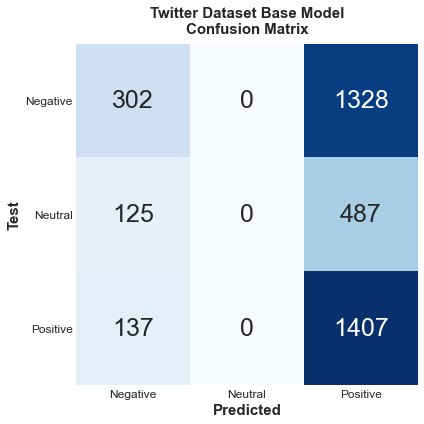

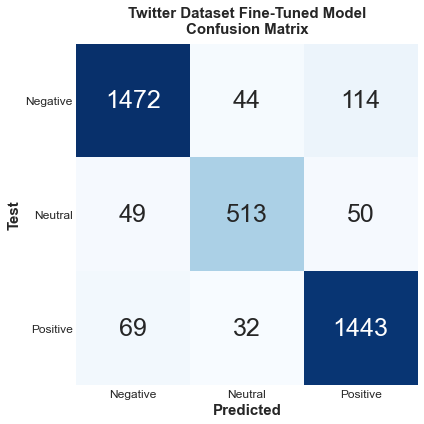

In [107]:
l = ['Negative', 'Neutral', 'Positive']
conf_matrix(y_test_tw.argmax(1),y_pred_tw_base.argmax(1), 'Twitter Dataset Base Model\nConfusion Matrix', l)
conf_matrix(y_test_tw.argmax(1),y_pred_tw_fine.argmax(1), 'Twitter Dataset Fine-Tuned Model\nConfusion Matrix', l)

## IMDB Dataset Testing

In [108]:
result_imdb_base = model_imdb_base.predict([x_test_imdb_ids, x_test_imdb_masks])
result_imdb_fine = model_imdb_fine.predict([x_test_imdb_ids, x_test_imdb_masks])

132/132 [==============================] - 50s 351ms/step


In [109]:
y_pred_imdb_base =  np.zeros_like(result_imdb_base)
y_pred_imdb_base[np.arange(len(y_pred_imdb_base)), result_imdb_base.argmax(1)] = 1

y_pred_imdb_fine =  np.zeros_like(result_imdb_fine)
y_pred_imdb_fine[np.arange(len(y_pred_imdb_fine)), result_imdb_fine.argmax(1)] = 1

In [110]:
print('\tIMDB Dataset Base Model\n')
print('\tAccuracy achieved:\t',np.round(accuracy_score(y_test_imdb, y_pred_imdb_base), 2))
print('\tClassification Report:\n\n',classification_report(y_test_imdb, y_pred_imdb_base, target_names=['negative', 'positive']))
print('-'*55,'\n')
print('\tIMDB Dataset Fine-Tuned Model\n')
print('\tAccuracy achieved:\t',np.round(accuracy_score(y_test_imdb, y_pred_imdb_fine), 2))
print('\tClassification Report:\n\n',classification_report(y_test_imdb, y_pred_imdb_fine, target_names=['negative', 'positive']))

	IMDB Dataset Base Model

	Accuracy achieved:	 0.72
	Classification Report:

               precision    recall  f1-score   support

    negative       0.77      0.63      0.69      2099
    positive       0.69      0.81      0.74      2115

   micro avg       0.72      0.72      0.72      4214
   macro avg       0.73      0.72      0.72      4214
weighted avg       0.73      0.72      0.72      4214
 samples avg       0.72      0.72      0.72      4214

------------------------------------------------------- 

	IMDB Dataset Fine-Tuned Model

	Accuracy achieved:	 0.92
	Classification Report:

               precision    recall  f1-score   support

    negative       0.95      0.89      0.92      2099
    positive       0.90      0.95      0.92      2115

   micro avg       0.92      0.92      0.92      4214
   macro avg       0.92      0.92      0.92      4214
weighted avg       0.92      0.92      0.92      4214
 samples avg       0.92      0.92      0.92      4214



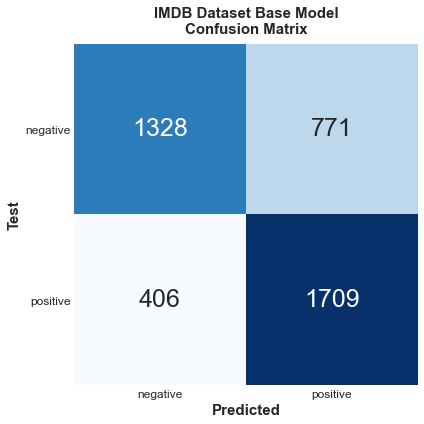

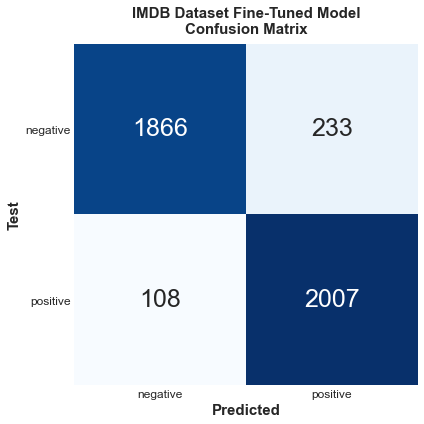

In [111]:
l = ['negative', 'positive']
conf_matrix(y_test_imdb.argmax(1),y_pred_imdb_base.argmax(1), 'IMDB Dataset Base Model\nConfusion Matrix', l)
conf_matrix(y_test_imdb.argmax(1),y_pred_imdb_fine.argmax(1), 'IMDB Dataset Fine-Tuned Model\nConfusion Matrix', l)

## Emotion Dataset Testing

In [112]:
result_em_base = model_emotion_base.predict([x_test_em_ids, x_test_em_masks])
result_em_fine = model_emotion_fine.predict([x_test_em_ids, x_test_em_masks])

63/63 [==============================] - 14s 176ms/step


In [113]:
y_pred_em_base =  np.zeros_like(result_em_base)
y_pred_em_base[np.arange(len(y_pred_em_base)), result_em_base.argmax(1)] = 1

y_pred_em_fine =  np.zeros_like(result_em_fine)
y_pred_em_fine[np.arange(len(y_pred_em_fine)), result_em_fine.argmax(1)] = 1

In [114]:
print('\t\tEmotion Dataset Base Model\n')
print('\tAccuracy achieved:\t',np.round(accuracy_score(y_test_em, y_pred_em_base), 2))
print('\tClassification Report:\n\n',classification_report(y_test_em, y_pred_em_base, target_names=['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']))
print('-'*55,'\n')
print('\t\tEmotion Dataset Fine-Tuned Model\n')
print('\tAccuracy achieved:\t',np.round(accuracy_score(y_test_em, y_pred_em_fine), 2))
print('\tClassification Report:\n\n',classification_report(y_test_em, y_pred_em_fine, target_names=['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']))

		Emotion Dataset Base Model

	Accuracy achieved:	 0.32
	Classification Report:

               precision    recall  f1-score   support

       anger       0.00      0.00      0.00       275
        fear       0.00      0.00      0.00       222
         joy       0.43      0.15      0.22       694
        love       0.00      0.00      0.00       159
     sadness       0.30      0.91      0.45       581
    surprise       0.00      0.00      0.00        66

   micro avg       0.32      0.32      0.32      1997
   macro avg       0.12      0.18      0.11      1997
weighted avg       0.24      0.32      0.21      1997
 samples avg       0.32      0.32      0.32      1997

------------------------------------------------------- 

		Emotion Dataset Fine-Tuned Model

	Accuracy achieved:	 0.93
	Classification Report:

               precision    recall  f1-score   support

       anger       0.98      0.90      0.94       275
        fear       0.88      0.88      0.88       222
         joy

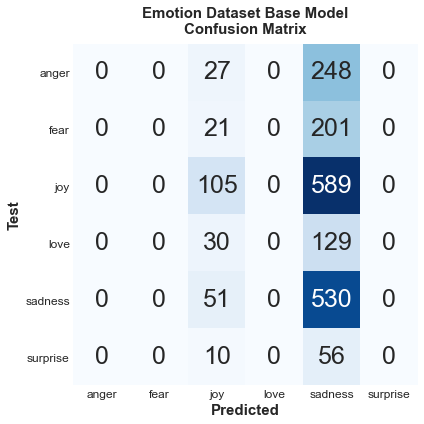

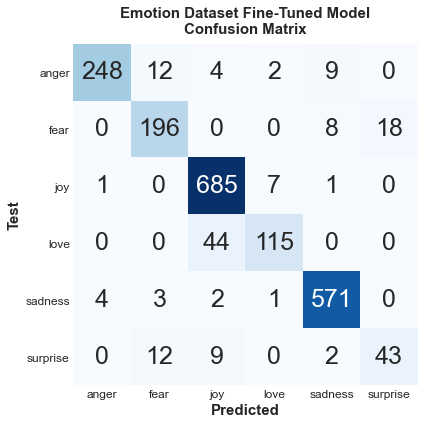

In [115]:
l = ['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']
conf_matrix(y_test_em.argmax(1),y_pred_em_base.argmax(1), 'Emotion Dataset Base Model\nConfusion Matrix', l)
conf_matrix(y_test_em.argmax(1),y_pred_em_fine.argmax(1), 'Emotion Dataset Fine-Tuned Model\nConfusion Matrix', l)

# Conclusioni

In [161]:
# costruisco gli input per i plot successivi

c_tw = ['Negative', 'Neutral', 'Positive']
df_base_tw = classification_report(y_test_tw, y_pred_tw_base, target_names=c_tw, output_dict=True)
df_base_tw = pd.DataFrame(df_base_tw).transpose()
df_base_tw = df_base_tw.apply(lambda x: np.round(x, 2))
acc_base_tw = np.round(accuracy_score(y_test_tw, y_pred_tw_base), 2)
df_fine_tw = classification_report(y_test_tw, y_pred_tw_fine, target_names=c_tw, output_dict=True)
df_fine_tw = pd.DataFrame(df_fine_tw).transpose()
df_fine_tw = df_fine_tw.apply(lambda x: np.round(x, 2))
acc_fine_tw = np.round(accuracy_score(y_test_tw, y_pred_tw_fine), 2)

c_imdb = ['negative', 'positive']
df_base_imdb = classification_report(y_test_imdb, y_pred_imdb_base, target_names=c_imdb, output_dict=True)
df_base_imdb = pd.DataFrame(df_base_imdb).transpose()
df_base_imdb = df_base_imdb.apply(lambda x: np.round(x, 2))
acc_base_imdb = np.round(accuracy_score(y_test_imdb, y_pred_imdb_base), 2)
df_fine_imdb = classification_report(y_test_imdb, y_pred_imdb_fine, target_names=c_imdb, output_dict=True)
df_fine_imdb = pd.DataFrame(df_fine_imdb).transpose()
df_fine_imdb = df_fine_imdb.apply(lambda x: np.round(x, 2))
acc_fine_imdb = np.round(accuracy_score(y_test_imdb, y_pred_imdb_fine), 2)

c_em = ['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']
df_base_em = classification_report(y_test_em, y_pred_em_base, target_names=c_em, output_dict=True)
df_base_em = pd.DataFrame(df_base_em).transpose()
df_base_em = df_base_em.apply(lambda x: np.round(x, 2))
acc_base_em = np.round(accuracy_score(y_test_em, y_pred_em_base), 2)
df_fine_em = classification_report(y_test_em, y_pred_em_fine, target_names=c_em, output_dict=True)
df_fine_em = pd.DataFrame(df_fine_em).transpose()
df_fine_em = df_fine_em.apply(lambda x: np.round(x, 2))
acc_fine_em = np.round(accuracy_score(y_test_em, y_pred_em_fine), 2)

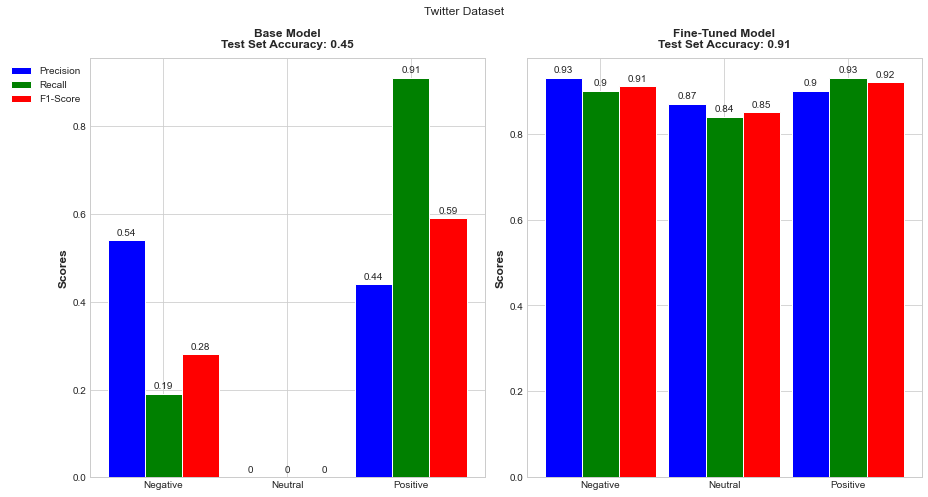

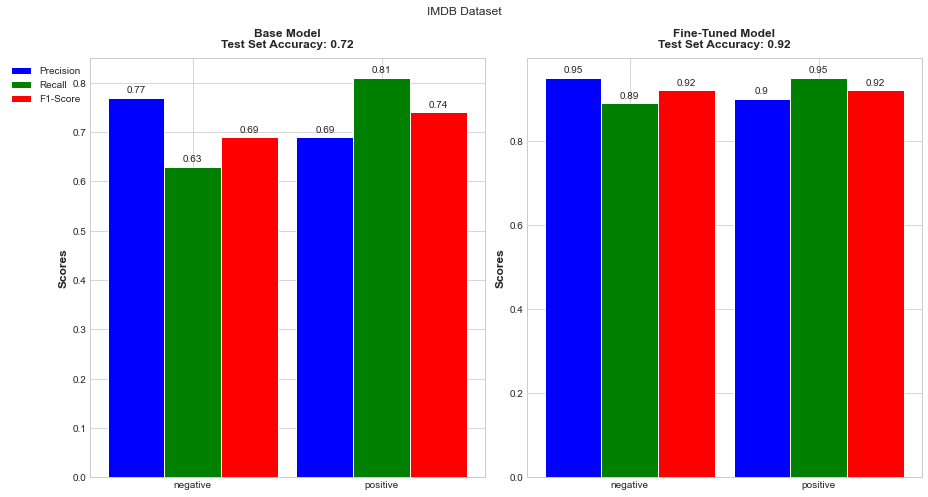

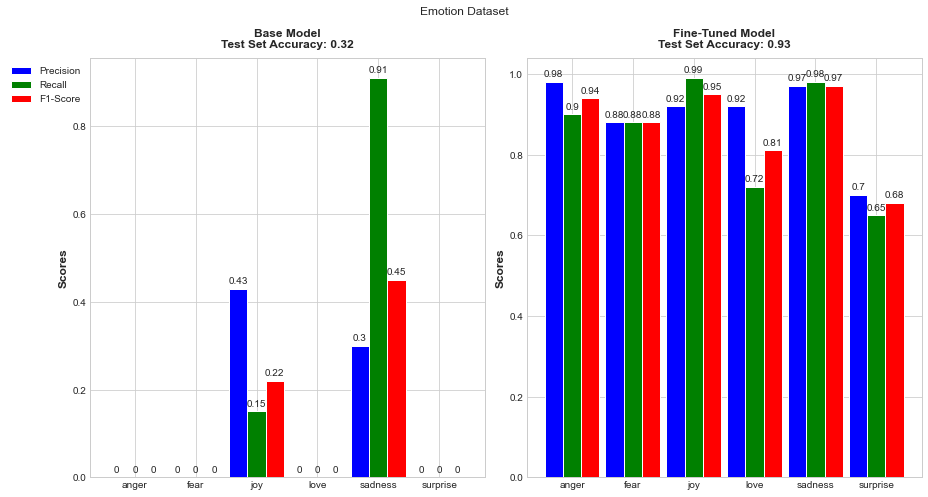

In [168]:
report_plot(df_base_tw, df_fine_tw, acc_base_tw, acc_fine_tw, c_tw, title='Twitter Dataset')
report_plot(df_base_imdb, df_fine_imdb, acc_base_imdb, acc_fine_imdb, c_imdb, title='IMDB Dataset')
report_plot(df_base_em, df_fine_em, acc_base_em, acc_fine_em, c_em, title='Emotion Dataset')